In [4]:
#LIBRARIES
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from datetime import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import random
import nibabel as nib
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    CropForegroundd,
)
from monai.networks.nets import SwinUNETR
import segmentation_models_pytorch as smp
import functions
import loaddata
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import transforms2

# Initialize TensorBoard
writer = SummaryWriter()
torch.cuda.empty_cache()

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#print_config()

experiment = "s4"
experiment_dir = f"/home/ilkin/Documents/2024PHD/segmentation/swinunetr/tests/OH-GLLES-3D/{experiment}"
json_path = f"{experiment_dir}/hyperparameters.json"

print(json_path)
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        hyperparams = json.load(f)

print(hyperparams)

# Functions to get additional parameters
lossfunc = functions.get_loss_func(hyperparams["diceCE"])
label_names, numberofclasses = functions.get_classes(hyperparams["dataset"], hyperparams["seg"])
dimension, batchsize = functions.get_dimension_and_bs(hyperparams["dataset"])
dice_roi, aug_roi = functions.get_rois(hyperparams["dataset"], hyperparams["architecture"])


# Update hyperparameters
hyperparams.update({
    "experiment": experiment,
    "number_of_classes": numberofclasses,
    "dimension": dimension,
    "batch_size": batchsize,
    "dice_roi": dice_roi,
    "aug_roi": aug_roi,
    "date_time": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),  # Log timestamp
    "loss_function": f"{lossfunc} ({hyperparams['wdice']}-{hyperparams['wce']})",
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "patience": 10
})

# Save the updated hyperparameters back to the JSON file
with open(json_path, "w") as f:
    json.dump(hyperparams, f, indent=4)

print("Hyperparameters updated and saved.")

if hyperparams["server"]:
    data_dir = os.path.join("/data/ayc9699/dataset", hyperparams["dataset"])
else:
    data_dir = os.path.join("/home/ilkin/Documents/2024PHD/data", hyperparams["dataset"])


cuda
/home/ilkin/Documents/2024PHD/segmentation/swinunetr/tests/OH-GLLES-3D/s4/hyperparameters.json
{'caption': 'Planning-CTs ROI OH GTV swinUNETR with pretraining', 'experiment': 's4', 'dataset': 'Planning-CTs', 'seg': 'GTV', 'modified': False, 'architecture': 'swinUNETR', 'server': False, 'pretraining': True, 'max_iterations': 20000, 'eval_num': 250, 'diceCE': True, 'wdice': 0.5, 'wce': 1.0, 'train_rt': 0.8, 'val_rt': 0.1, 'test_rt': 0.1, 'scheduler': 'ReduceLROnPlateau', 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'patience': 10, 'num_folds': 1, 'number_of_classes': 1, 'dimension': 3, 'batch_size': 1, 'date_time': '10/01/2025 16:24:19', 'loss_function': 'DiceCE Loss (0.5-1.0)', 'dice_roi': [512, 512, 200], 'aug_roi': [64, 64, 64]}
Hyperparameters updated and saved.


In [5]:
fold_splits = loaddata.get_train_val_test_files_5fold_planning(
    dataset=hyperparams["dataset"],
    data_dir=data_dir,
    train_rt=hyperparams["train_rt"], 
    val_rt=hyperparams["val_rt"], 
    test_rt=hyperparams["test_rt"],
    output_dir=experiment_dir,
    seg=hyperparams["seg"],
    modified=False,
    num_folds=hyperparams["num_folds"],
)

train_transforms = transforms2.getTrainTransformROI(dimension, aug_roi)
val_transforms = transforms2.getValTransformROI()
test_transforms = transforms2.getTestTransformROI(-175, 250)

Total number of patients: 188
Fixed Test Patients: 18
1-Fold Split:
  Training Patients: 152
  Validation Patients: 18
  Test Patients: 18


/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


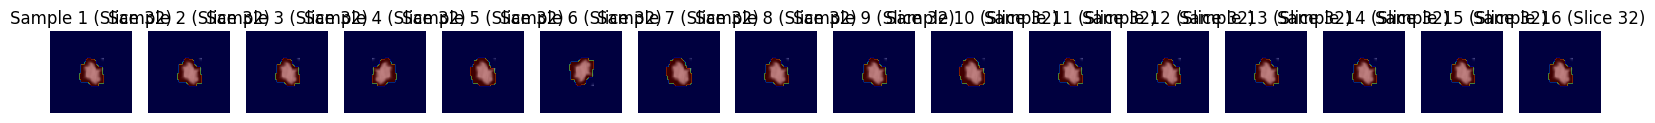

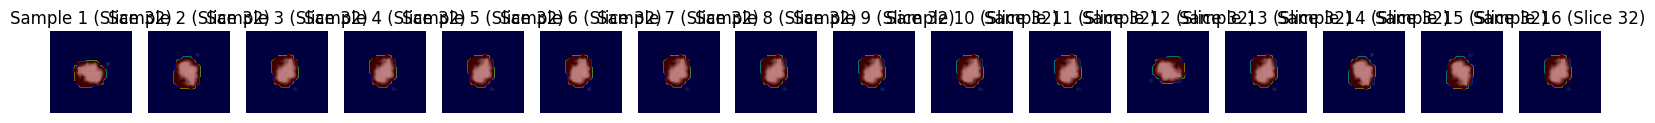

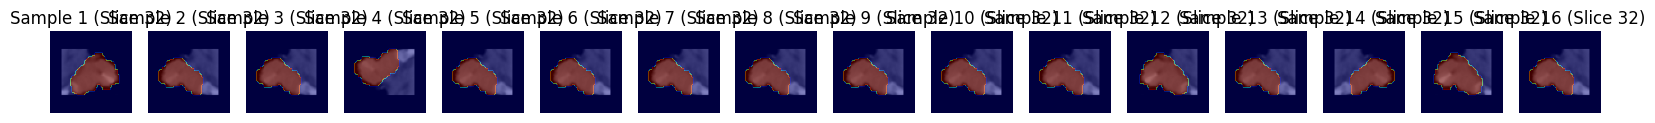

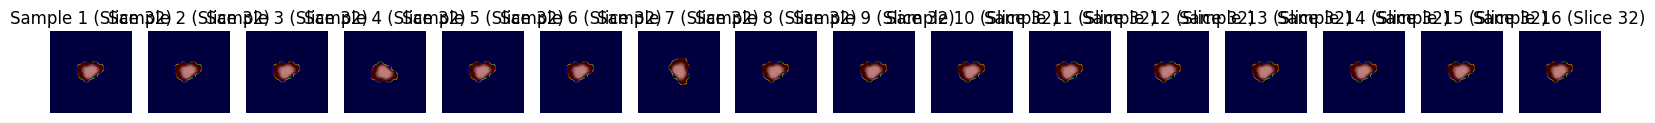

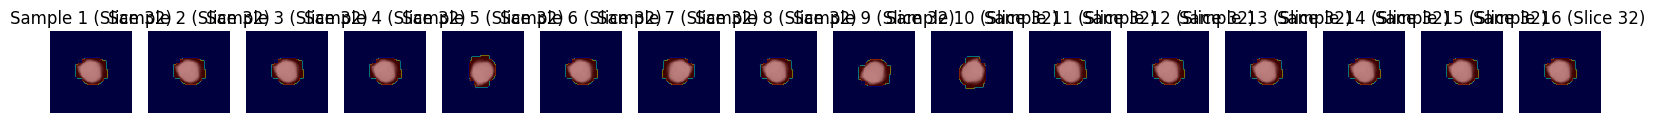

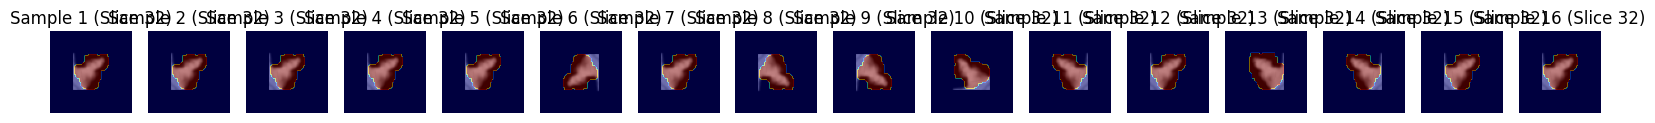

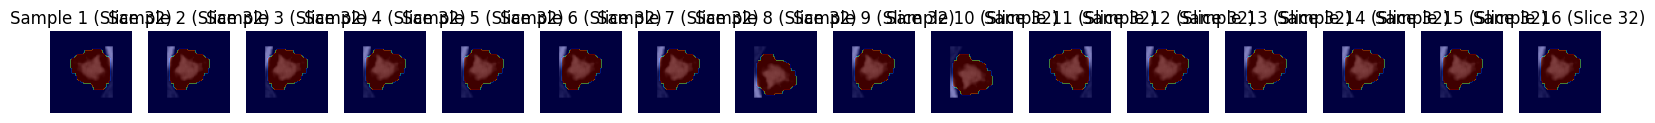

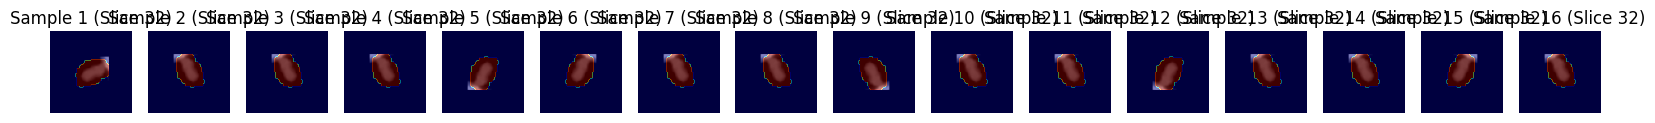

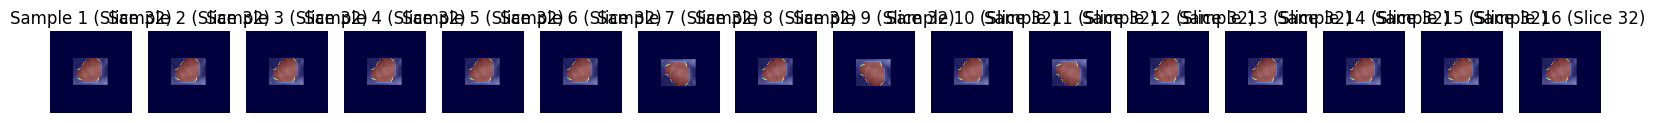

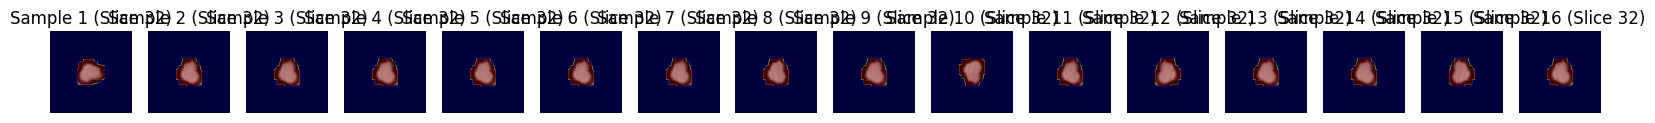

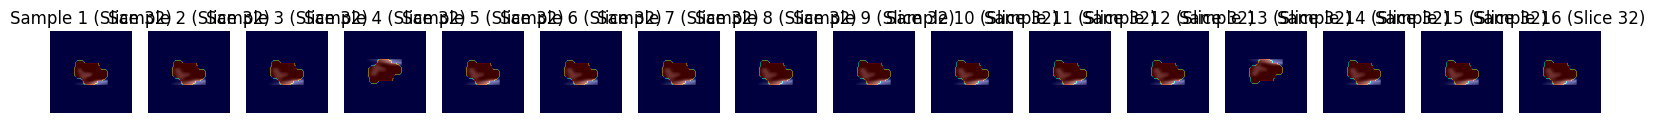

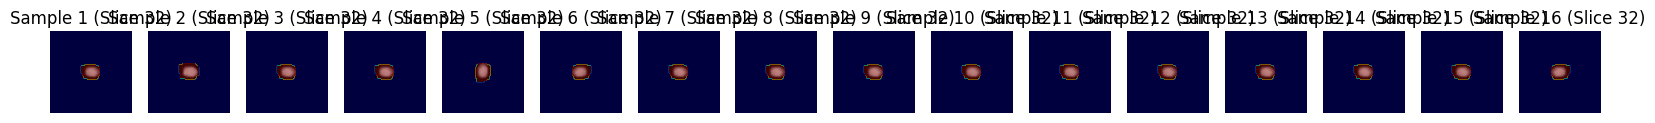

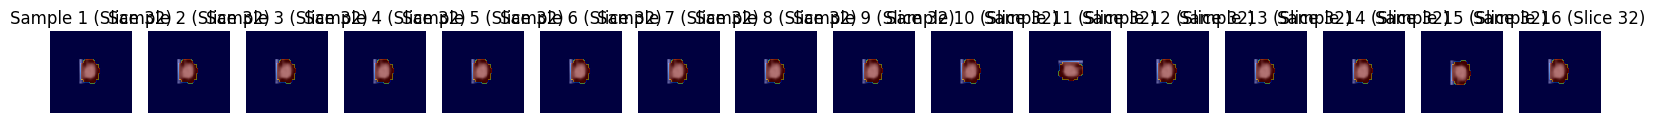

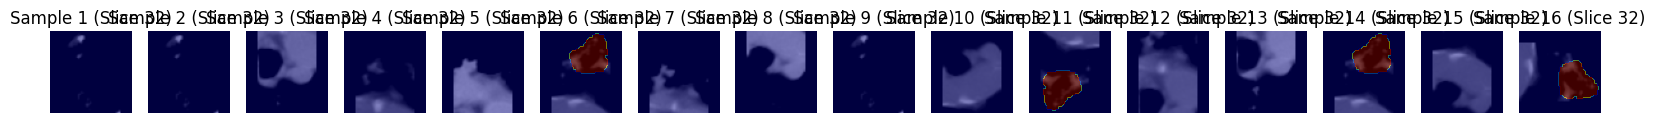

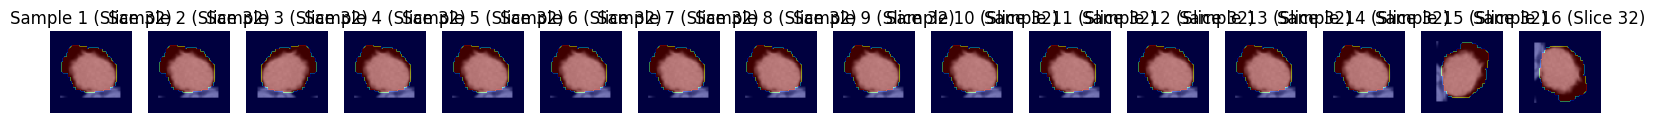

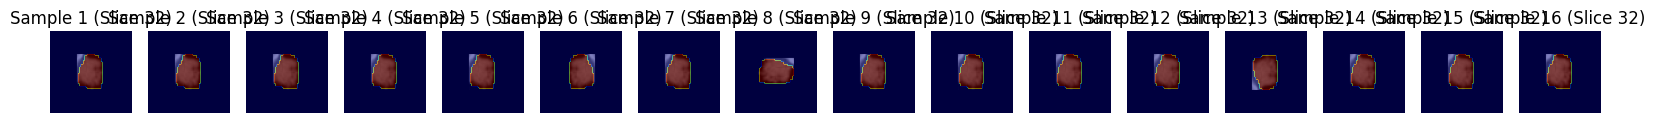

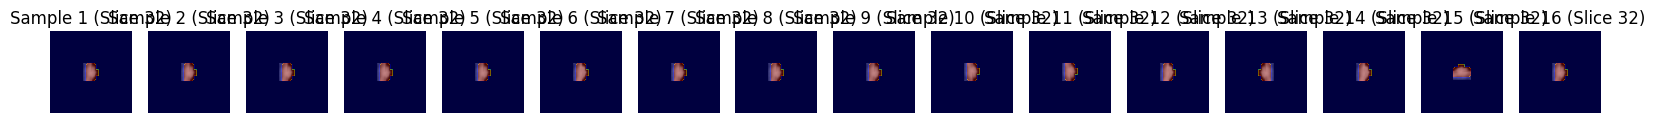

/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(


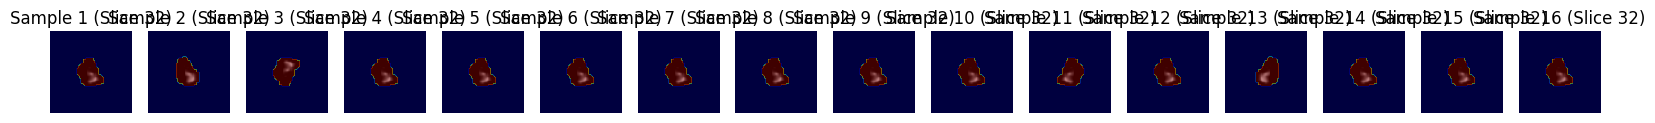

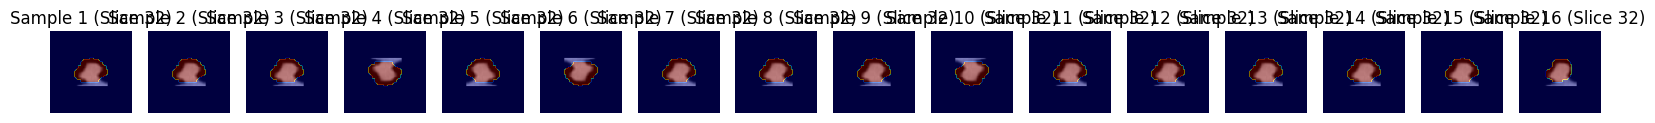

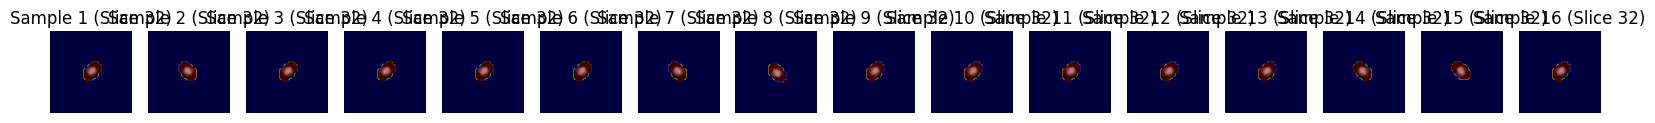

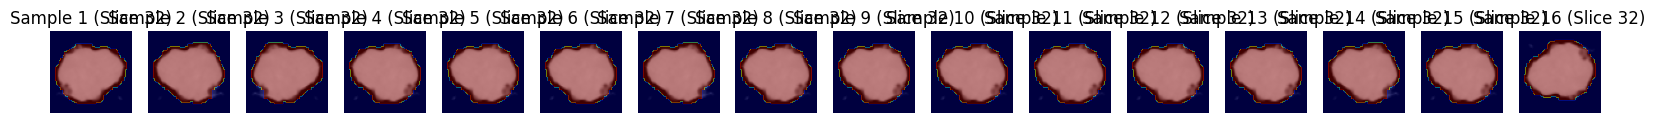

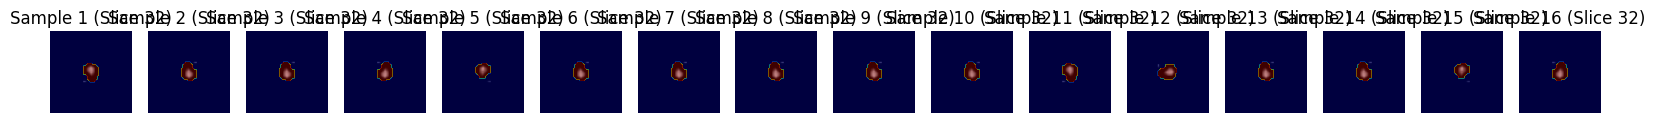

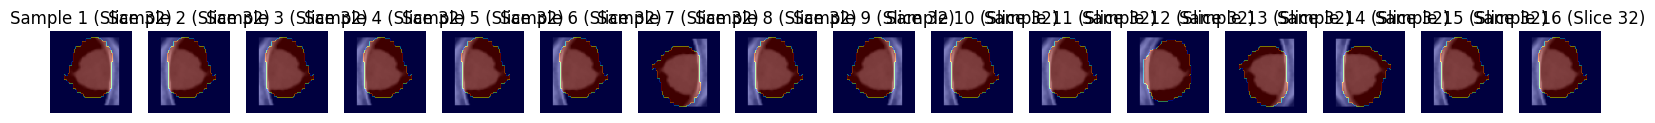

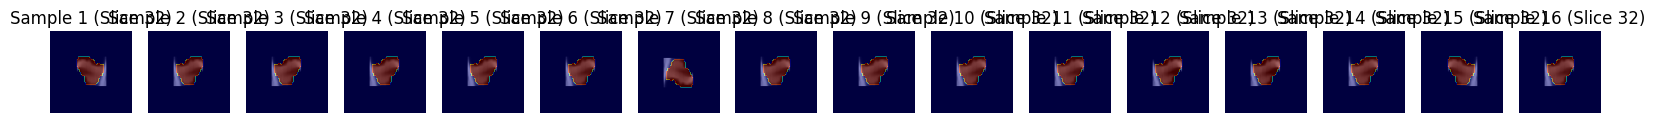

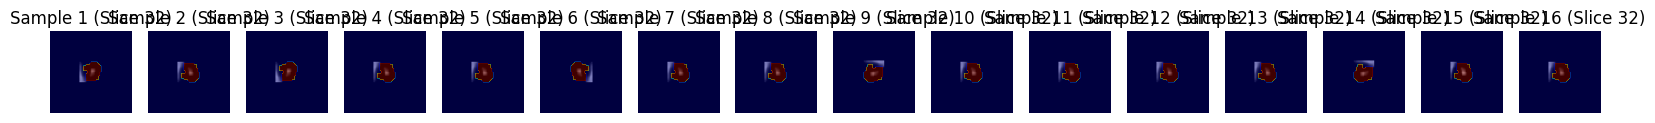

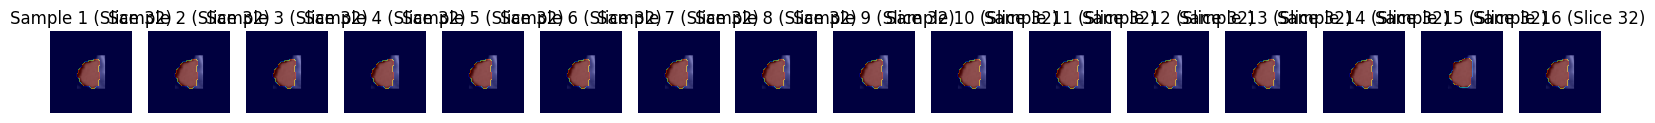

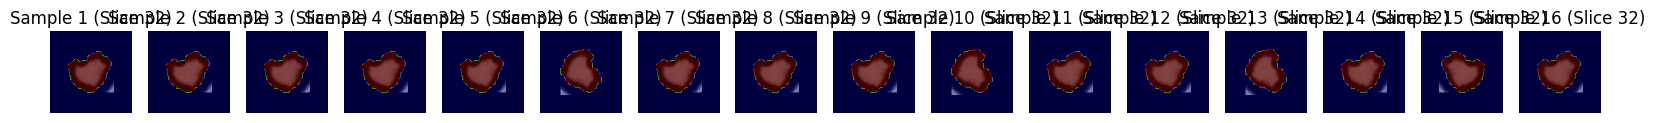

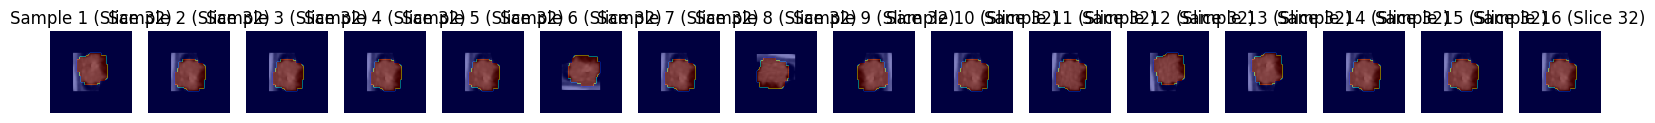

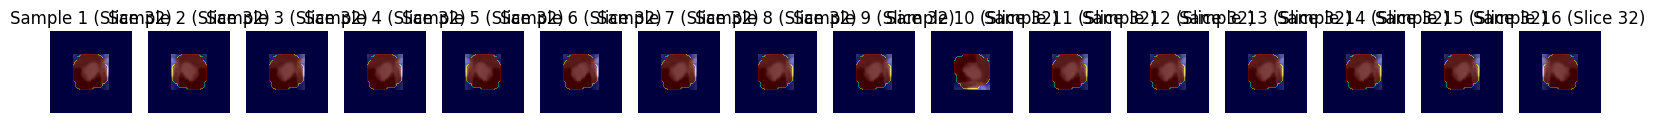

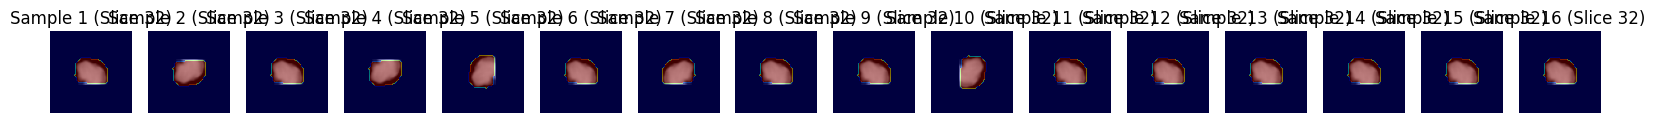

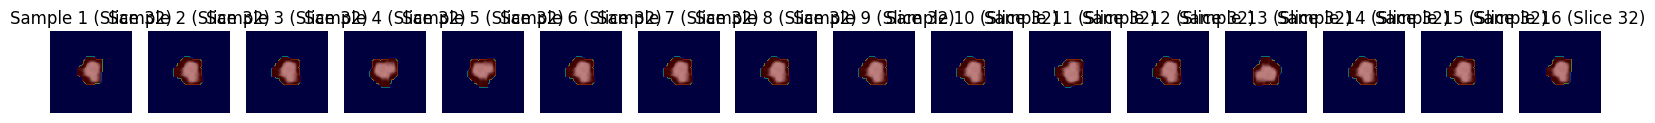

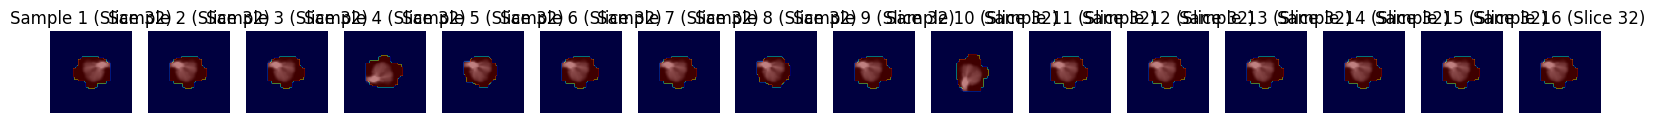

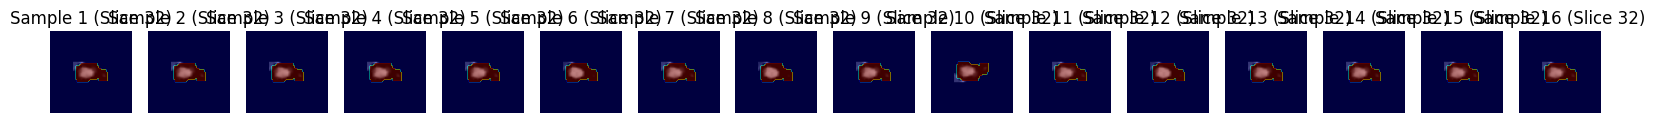

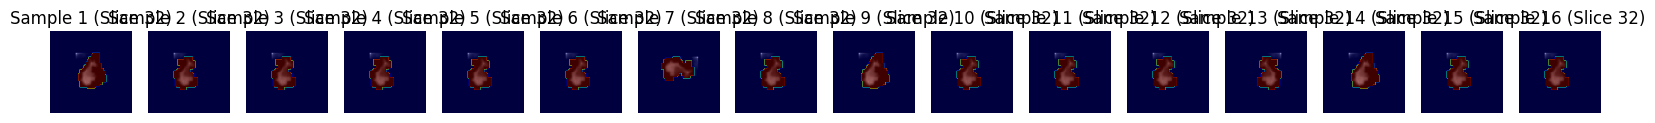

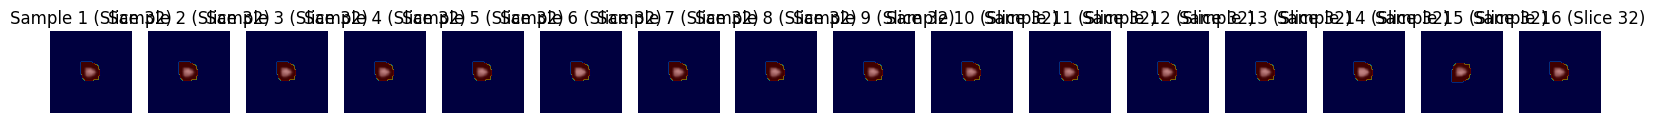

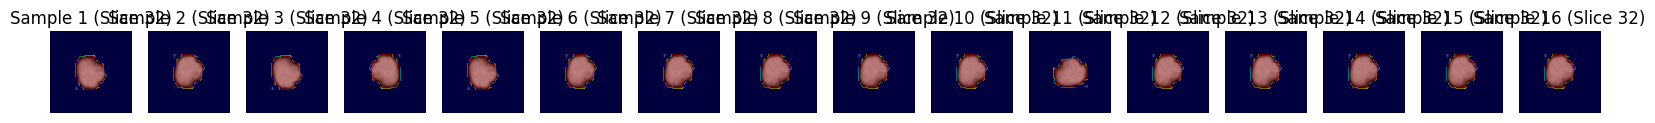

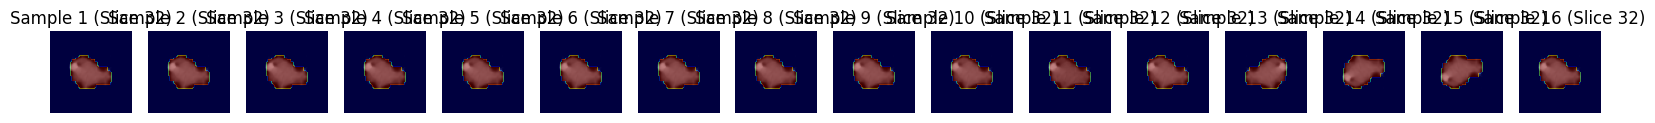

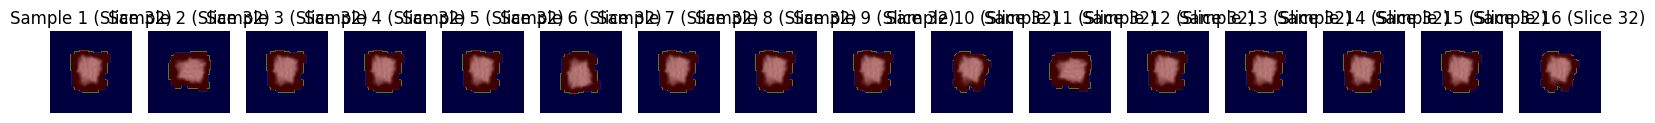

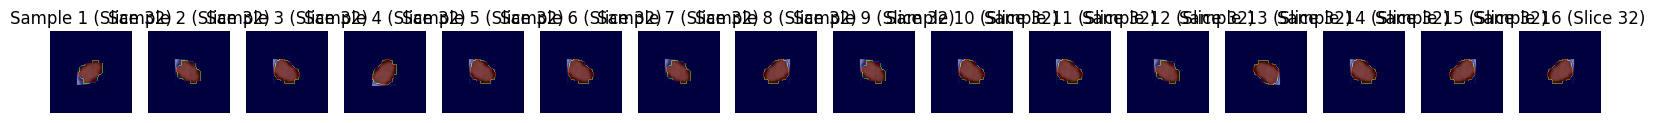

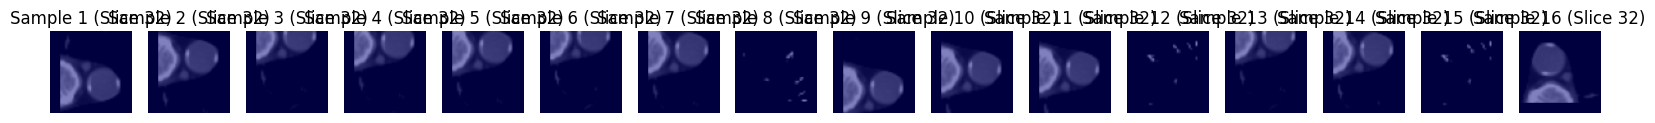

/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(


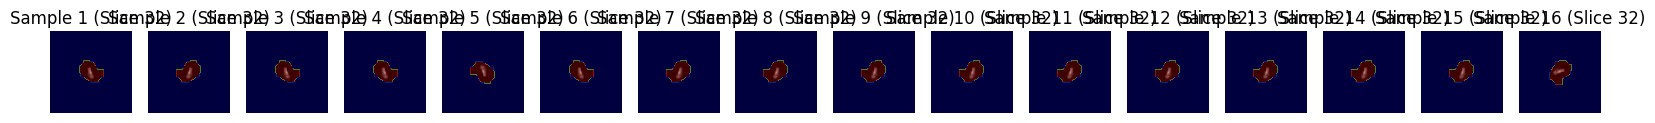

/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(


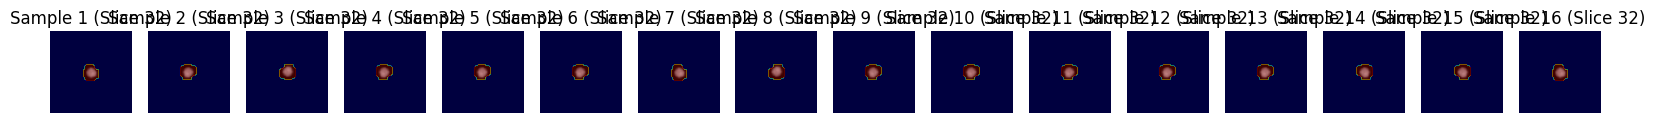

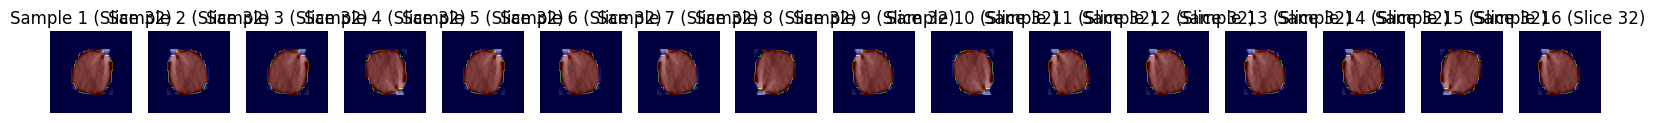

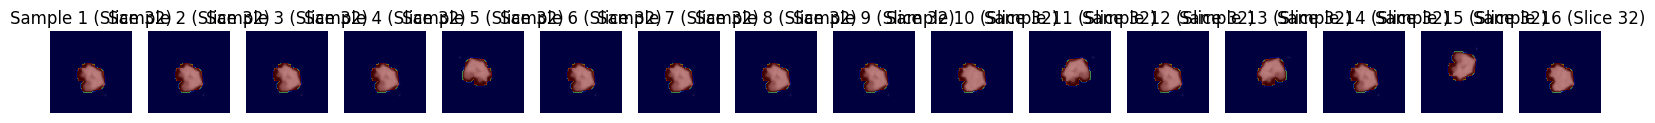

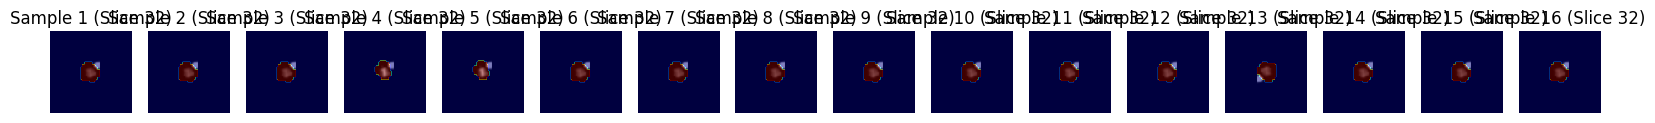

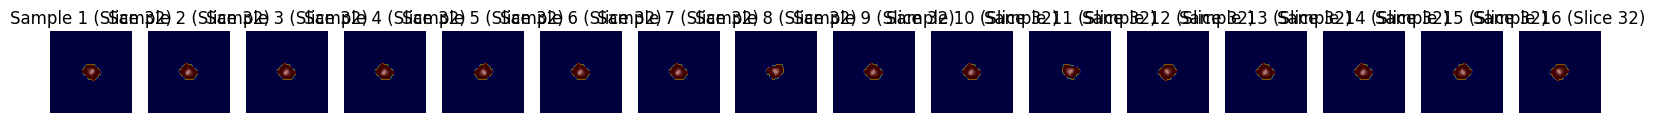

/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(


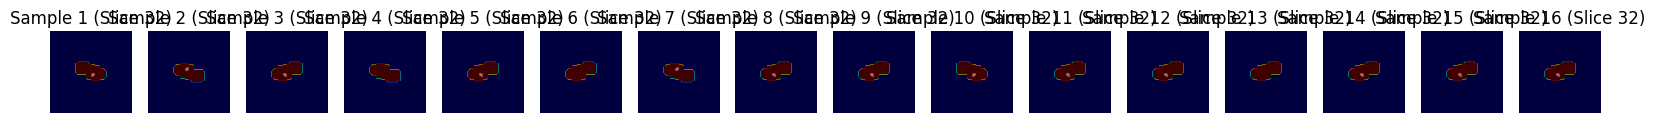

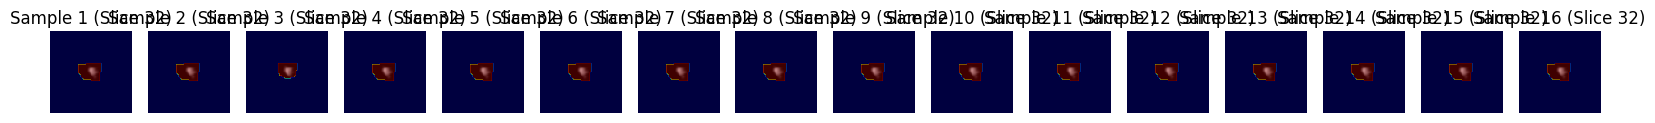

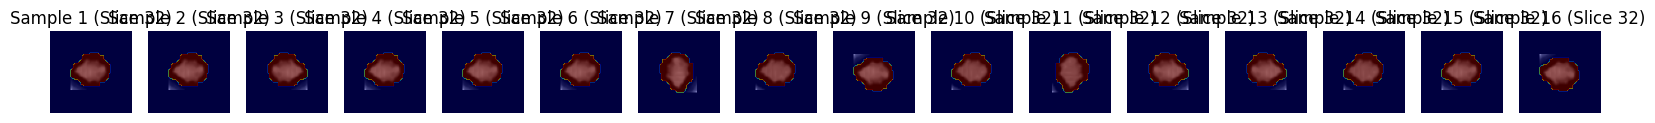

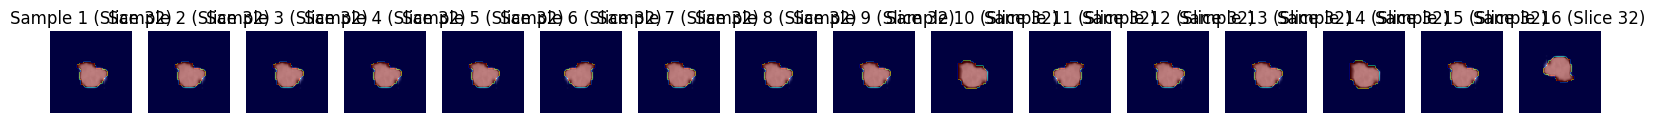

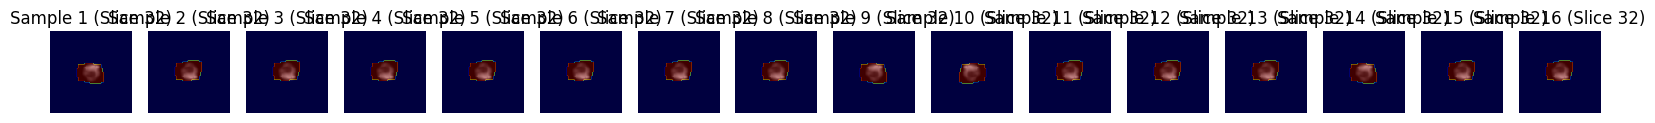

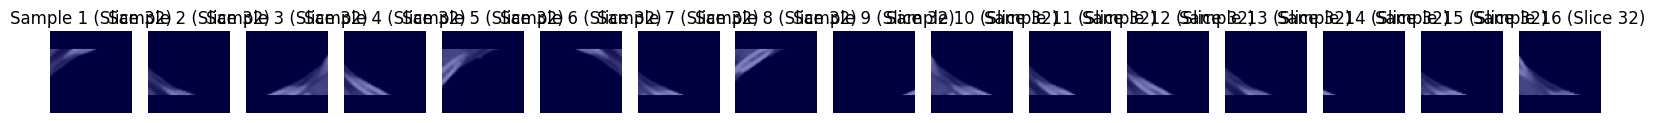

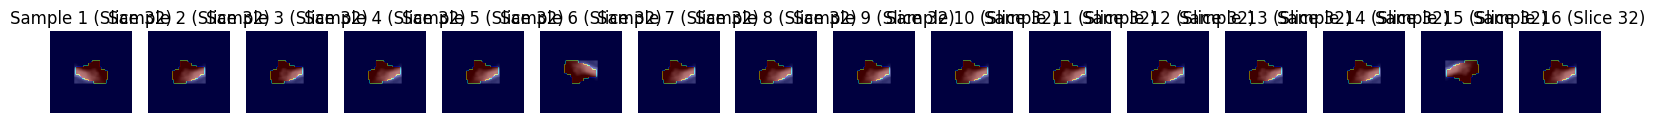

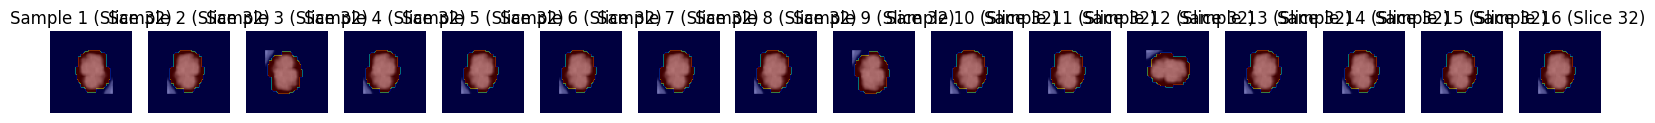

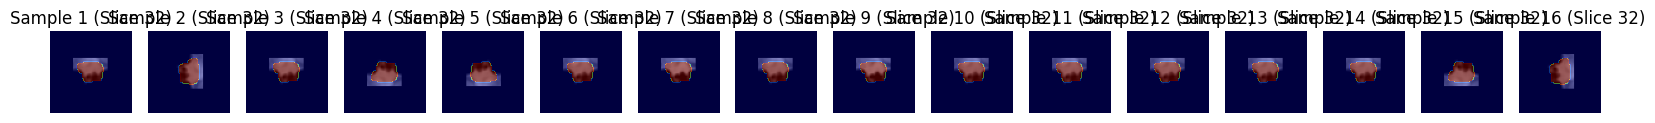

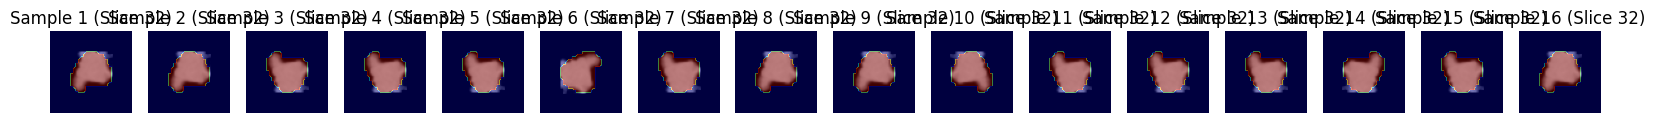

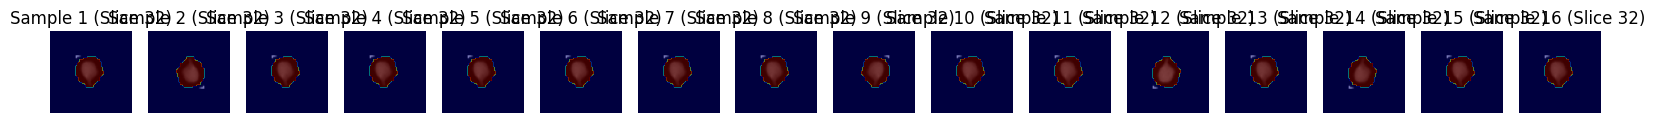

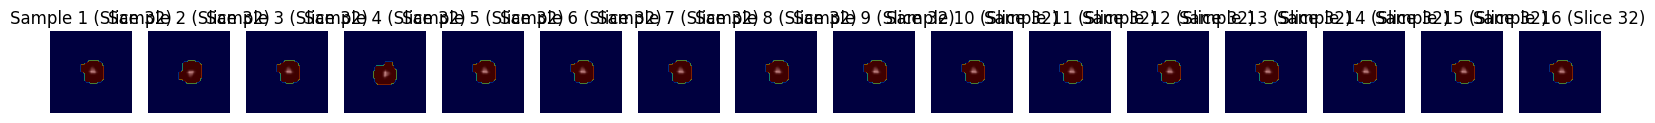

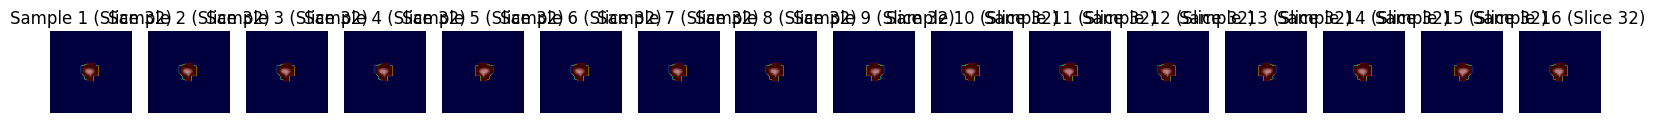

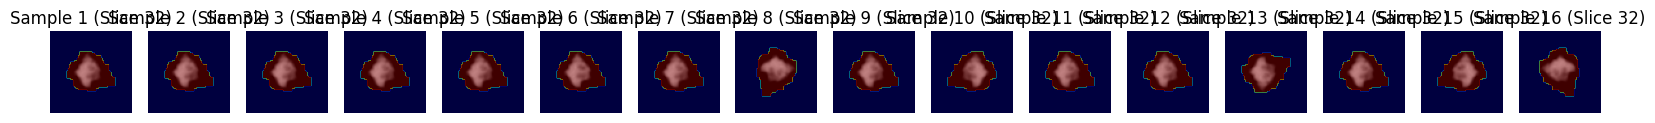

/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(


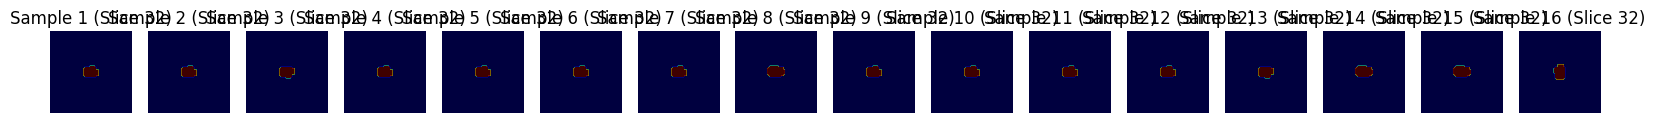

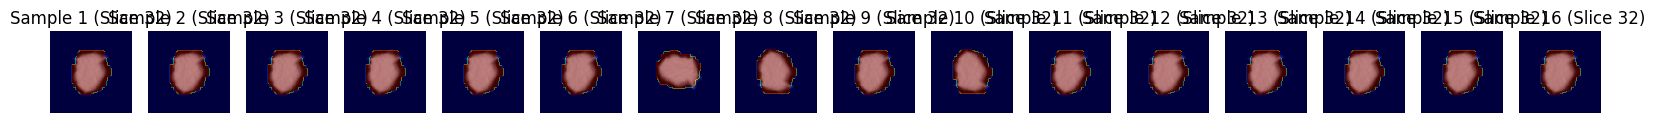

/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(


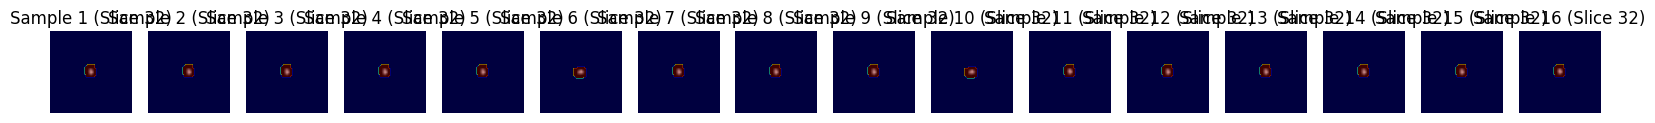

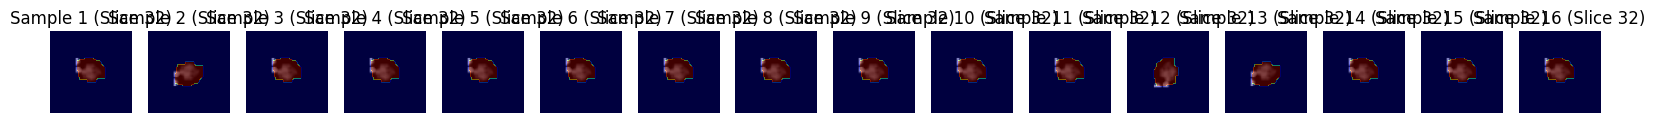

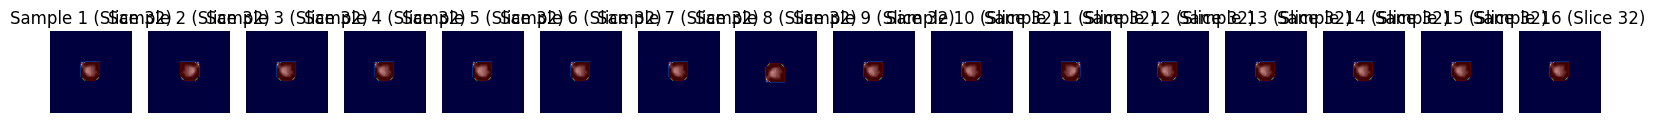

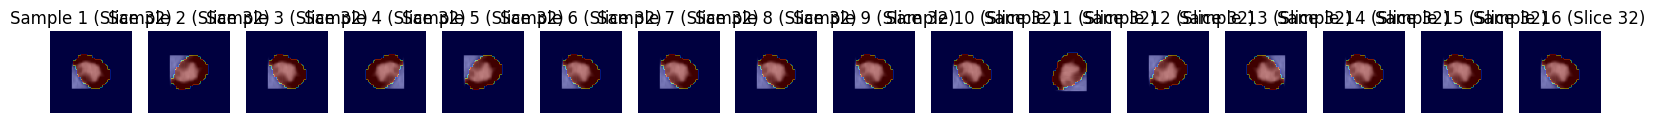

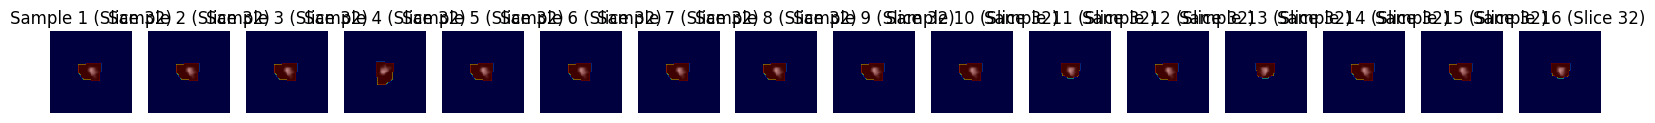

/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(


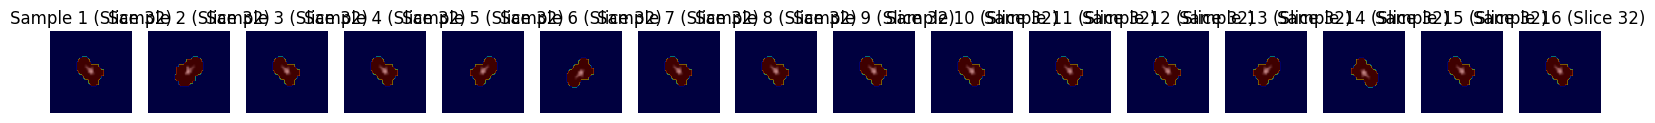

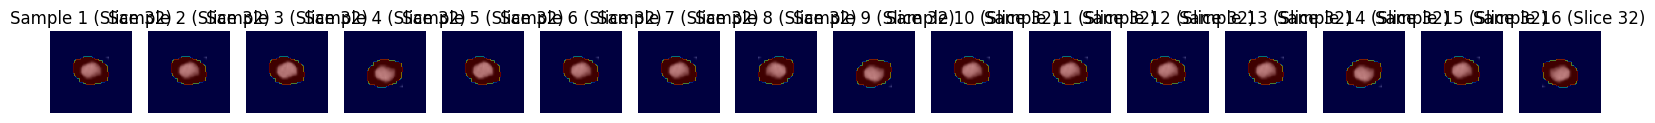

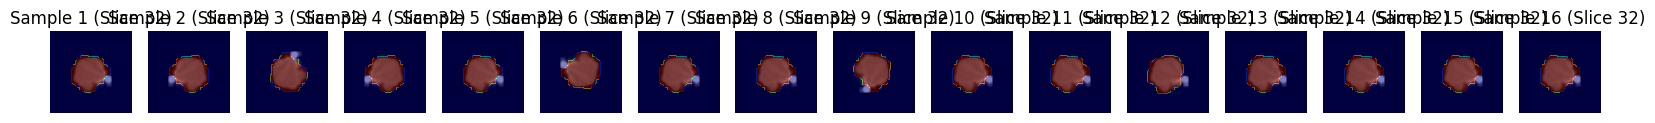

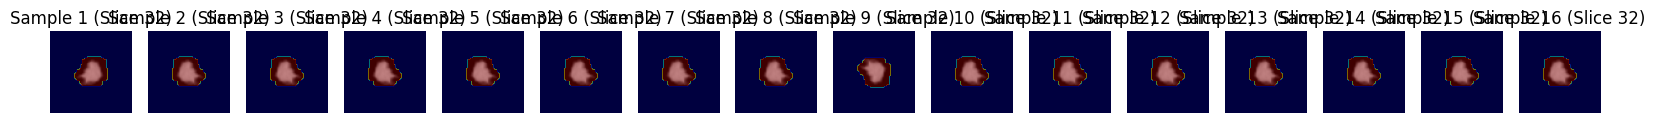

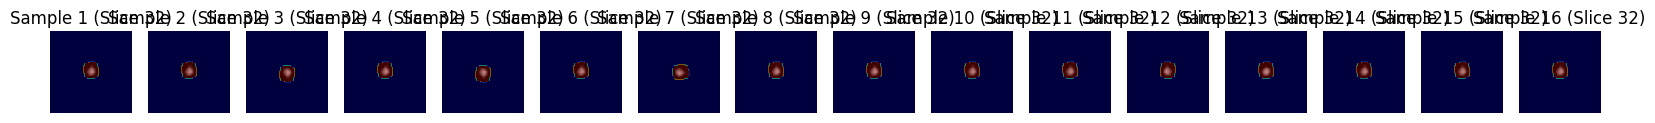

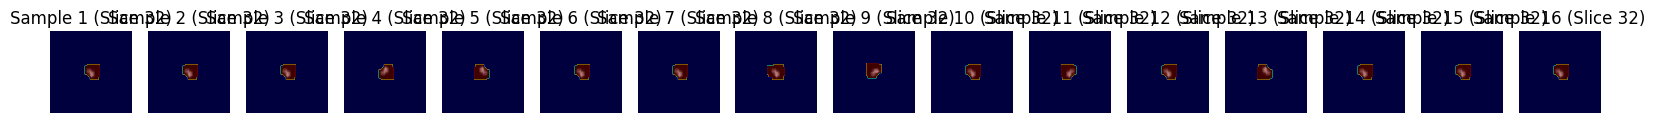

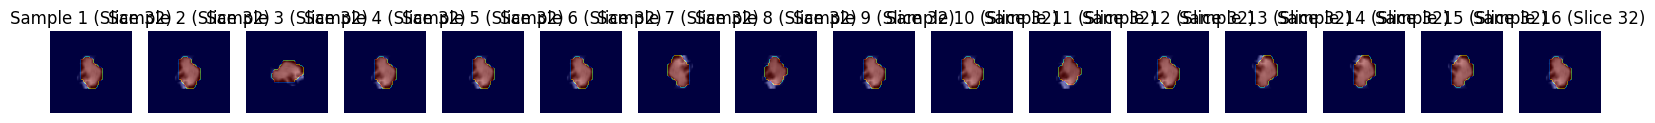

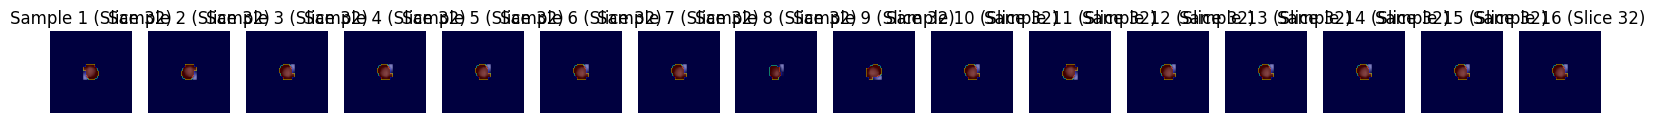

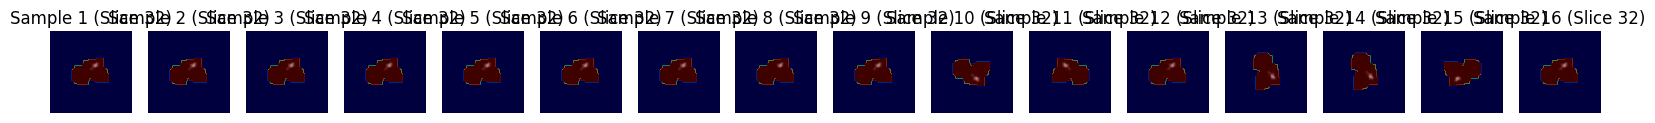

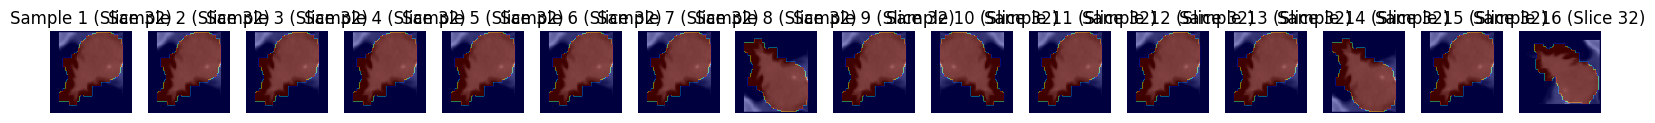

KeyboardInterrupt: 

In [9]:
fold_idx=0

train_dataset = Dataset(data=fold_splits[fold_idx]["train_files"], transform=train_transforms)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

# Define a function to visualize a batch of images with segmentation masks
def visualize_batch_with_masks(batch_data):
    fig, axes = plt.subplots(1, len(batch_data), figsize=(20, 5))

    for i, sample_data in enumerate(batch_data):
        sample_image = sample_data["image"]
        sample_mask = sample_data["mask"]

        # Convert image and mask to numpy array
        image_np = sample_image.squeeze().cpu().numpy()
        mask_np = sample_mask.squeeze().cpu().numpy()
        #print(np.unique(image_np))
        #print("image uniq", np.unique(image_np))
        #print("mask uq", np.unique(mask_np))


        # Check if the image and mask are 3D
        if len(image_np.shape) == 3:
            # Calculate the middle slice index
            slice_idx = image_np.shape[2] // 2

            # Plot the middle slice of the image
            axes[i].imshow(image_np[:, :, slice_idx], cmap="gray")

            # Overlay the middle slice of the mask
            axes[i].imshow(mask_np[:, :, slice_idx], cmap="jet", alpha=0.5)
            #axes[i].imshow(mask_np[:, :, slice_idx], cmap="cool", alpha=0.5)

            axes[i].set_title(f'Sample {i+1} (Slice {slice_idx})')
        else:
            axes[i].imshow(image_np, cmap="gray")
            axes[i].imshow(mask_np, cmap="cool", alpha=0.5)
            axes[i].set_title(f'Sample {i+1}')

        axes[i].axis('off')

    plt.show()
# Assuming train_loader is your DataLoader with the transformed dataset
for batch_data in train_data_loader:
    visualize_batch_with_masks(batch_data)
    #break  # Visualize only the first batch


In [4]:
#VALIDATION AND TRAINING FUNCTIONS

def validation(epoch_iterator_val):
    model.eval()
    meandiceperclass = np.zeros([numberofclasses+1])
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["mask"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, aug_roi, 4, model, overlap=0.5)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dm = dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
            meandiceperclass = meandiceperclass + dm[0]

        print(len(epoch_iterator_val))
        meandiceperclass = meandiceperclass/(len(epoch_iterator_val)+1)
        print(meandiceperclass)
        mean_dice_val = dice_metric.aggregate().item()
        print(mean_dice_val)
        
        dice_metric.reset()


    return meandiceperclass, mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best, patience, max_iterations, fold_dir):
    model.train()
    epoch_loss = 0
    step = 0
    no_improvement_count = 0  # Counter for early stopping
    
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["mask"].cuda())
        
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        # Save checkpoint every 5000 iterations
        if global_step % 5000 == 0:
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "global_step": global_step,
                "dice_val_best": dice_val_best,
            }
            print(fold_dir)
            checkpoint_path = os.path.join(fold_dir, f"checkpoint_step_{global_step}.pth")
            torch.save(checkpoint, checkpoint_path)
            print(f"Checkpoint saved at step {global_step} to {checkpoint_path}")

        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        
        if (global_step % hyperparams["eval_num"] == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val_cb, dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            metrics["train_loss"].append(epoch_loss)
            metrics["val_dice"].append(dice_val)
            scheduler.step(dice_val)
            metrics["val_dice_per_class"].append(dice_val_cb)
            writer.add_scalar('Loss/train', epoch_loss, global_step)
            writer.add_scalar('Dice/mean', dice_val, global_step)
            writer.add_scalar('Dice/tumor', dice_val_cb[1], global_step)
            writer.add_scalar('Dice/background', dice_val_cb[0], global_step)
            
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(fold_dir, "best_metric_model.pth" ))
                print("Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
                print(f"Current Dice for Tumor: {dice_val_cb[1]:.4f}, Background: {dice_val_cb[0]:.4f}")
                no_improvement_count = 0  # Reset the counter since there is an improvement
            else:
                print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
                print(f"Current Dice for Tumor: {dice_val_cb[1]:.4f}, Background: {dice_val_cb[0]:.4f}")
                no_improvement_count += 1  # Increment the counter for no improvement
            
            # Early stopping condition
            if no_improvement_count >= patience:
                print("Early stopping due to no improvement for {} consecutive epochs.".format(patience))
                return global_step, dice_val_best, global_step_best, True
        
        global_step += 1
    
    return global_step, dice_val_best, global_step_best, False


In [6]:
#uncomment to download the pre-trained weights
#!wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

In [5]:
#DEFINE MODEL 

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=numberofclasses+1,
    feature_size=48,
    use_checkpoint=True,
).to(device)

if hyperparams["pretraining"]:
    try:
        weight = torch.load("./model_swinvit.pt")
        model.load_from(weights=weight)
        print("Using pretrained self-supervied Swin UNETR backbone weights !")
    except FileNotFoundError:
        print("Pretrained weights not found. Training from scratch.")

# Loss, optimizer, scheduler
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=hyperparams["wdice"], lambda_ce=hyperparams["wce"])
optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=10, verbose=True)
scaler = torch.cuda.amp.GradScaler()

# Post-transforms and metrics
post_label = AsDiscrete(to_onehot=numberofclasses + 1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses + 1)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Assuming `model` is your network instance
def print_model_weights(model):
    for name, param in model.named_parameters():
        print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]}...")  # Shows first 2 weights of each parameter

# Example usage
#print_model_weights(model)


Using pretrained self-supervied Swin UNETR backbone weights !


In [ ]:
# Function to recursively convert ndarrays in the metrics dictionary to lists
def convert_ndarray_to_list(data):
    if isinstance(data, dict):
        return {key: convert_ndarray_to_list(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_ndarray_to_list(item) for item in data]
    elif isinstance(data, np.ndarray):
        return data.tolist()
    else:
        return data

In [6]:
# Training loop for all folds
for fold_idx, fold_split in enumerate(fold_splits):
    fold_dir = os.path.join(experiment_dir, f"fold_{fold_idx+1}")

    print(f"Starting training for Fold {fold_idx + 1} / {len(fold_splits)}")
    
    # Set up DataLoaders for this fold
    train_loader = DataLoader(
        CacheDataset(data=fold_split["train_files"], transform=train_transforms, cache_rate=0.1, num_workers=4),
        batch_size=batchsize, shuffle=True, num_workers=4
    )
    val_loader = DataLoader(
        CacheDataset(data=fold_split["val_files"], transform=val_transforms, cache_rate=0.1, num_workers=4),
        batch_size=1, num_workers=4
    )
    
    # Reset training state variables for this fold
    global_step, dice_val_best, global_step_best = 0, 0.0, 0
    patience = hyperparams["patience"]  # Adjust as needed
    max_iterations = hyperparams["max_iterations"]
    early_stopping = False
    
    # Metrics for this fold
    metrics = {
        "fold_idx": fold_idx + 1,            # Fold number
        "train_loss": [],                   # List of training losses per epoch
        "val_loss": [],                     # List of validation losses per epoch
        "val_dice": [],                     # Global Dice score across all classes
        "val_dice_per_class": [],           # Per-class Dice scores (e.g., [background, tumor])
        "best_tumor_dice": 0.0,             # Best tumor Dice score
        "best_iteration": 0,                # Iteration where best tumor Dice occurred
        "learning_rate": [],                # Learning rate per epoch
    }

    torch.backends.cudnn.benchmark = True

    while global_step < max_iterations:

        global_step, dice_val_best, global_step_best, early_stopping = train(
            global_step,
            train_loader,
            dice_val_best,
            global_step_best,
            patience,
            max_iterations,
            fold_dir
        )
        # Log current learning rate
        current_lr = optimizer.param_groups[0]["lr"]
        metrics["learning_rate"].append(current_lr)
        
        if early_stopping:
            print(f"Early stopping triggered for Fold {fold_idx + 1} at iteration {global_step}.")
            metrics["early_stopping"] = {
                "iteration": global_step,
                "reason": "No improvement for {} consecutive evaluations.".format(patience),
            }
            break
    
    # Save best model path for this fold
    best_model_path = os.path.join(fold_dir, "best_metric_model.pth")
    print(f"Training completed for Fold {fold_idx + 1}. Best Tumor Dice: {dice_val_best:.4f}")

    # Save the final model as a checkpoint
    final_checkpoint_path = os.path.join(fold_dir, "final_checkpoint_model.pth")
    torch.save(model.state_dict(), final_checkpoint_path)
    print(f"Final checkpoint saved to {final_checkpoint_path}")

    # Log metrics for this fold
    metrics["best_tumor_dice"] = dice_val_best
    metrics["best_iteration"] = global_step_best
    metrics["final_iteration"] = global_step  # Log the final iteration
    metrics_serializable = convert_ndarray_to_list(metrics)
    metrics_path = os.path.join(fold_dir, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics_serializable, f)

    print(f"Metrics saved to {metrics_path}")

# Log all fold-level results at the end of the training
if fold_idx == len(fold_splits) - 1:
    fold_results_path = os.path.join(experiment_dir, "fold_results.json")
    fold_results = {f"fold_{fold['fold']}": convert_ndarray_to_list(metrics) for fold in fold_splits}

    with open(fold_results_path, "w") as f:
        json.dump(fold_results, f)
    print(f"Fold-level results saved to {fold_results_path}")


Starting training for Fold 1 / 1


Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]

/home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1


Training (0 / 20000 Steps) (loss=1.07982):   1%|          | 1/152 [00:09<24:12,  9.62s/it]

Checkpoint saved at step 0 to /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/checkpoint_step_0.pth


Training (1 / 20000 Steps) (loss=1.01047):   1%|▏         | 2/152 [00:10<11:07,  4.45s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8 / 20000 Steps) (loss=0.88331):   6%|▌         | 9/152 [00:16<02:22,  1.00it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10 / 20000 Steps) (loss=0.84956):   7%|▋         | 11/152 [00:18<02:09,  1.09it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16 / 20000 

18
[0.93781035 0.71843403]
0.8741289973258972


Training (250 / 20000 Steps) (loss=0.30850):  65%|██████▌   | 99/152 [01:35<03:03,  3.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8741289973258972 Current Avg. Dice: 0.8741289973258972
Current Dice for Tumor: 0.7184, Background: 0.9378


Training (253 / 20000 Steps) (loss=0.30788):  67%|██████▋   | 102/152 [01:38<01:27,  1.75s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (269 / 20000 Steps) (loss=0.21114):  78%|███████▊  | 118/152 [01:51<00:29,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (277 / 20000 Steps) (loss=0.31350):  83%|████████▎ | 126/152 [01:58<00:22,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.9398786  0.75196127]
0.8929154872894287


Training (500 / 20000 Steps) (loss=0.21013):  30%|██▉       | 45/152 [00:49<06:20,  3.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8929154872894287 Current Avg. Dice: 0.8929154872894287
Current Dice for Tumor: 0.7520, Background: 0.9399


Training (511 / 20000 Steps) (loss=0.19309):  37%|███▋      | 56/152 [00:58<01:26,  1.11it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (519 / 20000 Steps) (loss=0.25040):  42%|████▏     | 64/152 [01:05<01:14,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (522 / 20000 Steps) (loss=0.41899):  44%|████▍     | 67/152 [01:07<01:12,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (526 

18
[0.93876092 0.73319325]
0.8824202418327332
Model Was Not Saved ! Current Best Avg. Dice: 0.8929154872894287 Current Avg. Dice: 0.8824202418327332
Current Dice for Tumor: 0.7332, Background: 0.9388


Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (760 / 20000 Steps) (loss=0.18359):   1%|          | 1/152 [00:02<06:48,  2.71s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (762 / 20000 Steps) (loss=0.12470):   2%|▏         | 3/152 [00:04<03:08,  1.27s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (793 / 20000 Steps) (loss

18
[0.93959273 0.74785203]
0.8905958533287048
Model Was Not Saved ! Current Best Avg. Dice: 0.8929154872894287 Current Avg. Dice: 0.8905958533287048
Current Dice for Tumor: 0.7479, Background: 0.9396


Training (1007 / 20000 Steps) (loss=0.16777):  63%|██████▎   | 96/152 [01:31<00:59,  1.06s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (1016 / 20000 Steps) (loss=0.19243):  69%|██████▉   | 105/152 [01:39<00:40,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (1018 / 20000 Steps) (loss=0.17347):  70%|███████   | 107/152 [01:41<00:38,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.93993408 0.74610604]
0.8898545503616333
Model Was Not Saved ! Current Best Avg. Dice: 0.8929154872894287 Current Avg. Dice: 0.8898545503616333
Current Dice for Tumor: 0.7461, Background: 0.9399


Training (1284 / 20000 Steps) (loss=0.17791):  45%|████▌     | 69/152 [01:09<01:10,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (1295 / 20000 Steps) (loss=0.15085):  53%|█████▎    | 80/152 [01:18<01:01,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (1323 / 20000 Steps) (loss=0.08497):  71%|███████   | 108/152 [01:42<00:37,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training 

18
[0.94020971 0.75739646]
0.8959587812423706


Training (1500 / 20000 Steps) (loss=0.15842):  88%|████████▊ | 133/152 [02:04<01:07,  3.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8959587812423706 Current Avg. Dice: 0.8959587812423706
Current Dice for Tumor: 0.7574, Background: 0.9402


Training (1520 / 20000 Steps) (loss=0.09899):   1%|          | 1/152 [00:02<07:06,  2.83s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (1542 / 20000 Steps) (loss=0.08651):  15%|█▌        | 23/152 [00:21<01:50,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (1543 / 20000 Steps) (loss=0.08811):  16%|█▌        | 24/152 [00:22<01:50,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15

18
[0.93990881 0.75659213]
0.8953755497932434
Model Was Not Saved ! Current Best Avg. Dice: 0.8959587812423706 Current Avg. Dice: 0.8953755497932434
Current Dice for Tumor: 0.7566, Background: 0.9399


Training (1779 / 20000 Steps) (loss=0.09144):  71%|███████   | 108/152 [01:42<00:37,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (1780 / 20000 Steps) (loss=0.07240):  72%|███████▏  | 109/152 [01:43<00:36,  1.19it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (1808 / 20000 Steps) (loss=0.12682):  90%|█████████ | 137/152 [02:07<00:12,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.94013018 0.7528159 ]
0.8934993743896484
Model Was Not Saved ! Current Best Avg. Dice: 0.8959587812423706 Current Avg. Dice: 0.8934993743896484
Current Dice for Tumor: 0.7528, Background: 0.9401


Training (2004 / 20000 Steps) (loss=0.11474):  19%|█▉        | 29/152 [00:35<03:01,  1.47s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2009 / 20000 Steps) (loss=0.13277):  22%|██▏       | 34/152 [00:39<01:53,  1.04it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2017 / 20000 Steps) (loss=0.08898):  28%|██▊       | 42/152 [00:46<01:34,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94054711 0.76809736]
0.9017845988273621


Training (2250 / 20000 Steps) (loss=0.06385):  81%|████████  | 123/152 [01:55<01:42,  3.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9017845988273621 Current Avg. Dice: 0.9017845988273621
Current Dice for Tumor: 0.7681, Background: 0.9405


Training (2261 / 20000 Steps) (loss=0.06308):  88%|████████▊ | 134/152 [02:04<00:16,  1.11it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2269 / 20000 Steps) (loss=0.10897):  93%|█████████▎| 142/152 [02:11<00:08,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2270 / 20000 Steps) (loss=0.10993):  94%|█████████▍| 143/152 [02:12<00:07,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94031342 0.75696501]
0.8957858681678772
Model Was Not Saved ! Current Best Avg. Dice: 0.9017845988273621 Current Avg. Dice: 0.8957858681678772
Current Dice for Tumor: 0.7570, Background: 0.9403


Training (2511 / 20000 Steps) (loss=0.06617):  53%|█████▎    | 80/152 [01:19<01:04,  1.12it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2512 / 20000 Steps) (loss=0.20194):  53%|█████▎    | 81/152 [01:19<01:02,  1.13it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2532 / 20000 Steps) (loss=0.08509):  66%|██████▋   | 101/152 [01:36<00:43,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training 

18
[0.94044883 0.76782165]
0.901587188243866
Model Was Not Saved ! Current Best Avg. Dice: 0.9017845988273621 Current Avg. Dice: 0.901587188243866
Current Dice for Tumor: 0.7678, Background: 0.9404


Training (2780 / 20000 Steps) (loss=0.04501):  30%|██▉       | 45/152 [00:49<01:31,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2785 / 20000 Steps) (loss=0.18085):  33%|███▎      | 50/152 [00:53<01:27,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2790 / 20000 Steps) (loss=0.06573):  36%|███▌      | 55/152 [00:57<01:23,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (2

18
[0.94064232 0.76717708]
0.9013491868972778
Model Was Not Saved ! Current Best Avg. Dice: 0.9017845988273621 Current Avg. Dice: 0.9013491868972778
Current Dice for Tumor: 0.7672, Background: 0.9406


Training (3025 / 20000 Steps) (loss=0.05098):  91%|█████████ | 138/152 [02:07<00:11,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (3046 / 20000 Steps) (loss=0.10042):   5%|▍         | 7/152 [00:07<02:13,  1.09it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (3054 / 20000 Steps) 

18
[0.94052425 0.76397926]
0.8995990753173828
Model Was Not Saved ! Current Best Avg. Dice: 0.9017845988273621 Current Avg. Dice: 0.8995990753173828
Current Dice for Tumor: 0.7640, Background: 0.9405


Training (3255 / 20000 Steps) (loss=0.16352):  42%|████▏     | 64/152 [01:05<01:53,  1.29s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (3281 / 20000 Steps) (loss=0.07983):  59%|█████▉    | 90/152 [01:27<00:53,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (3297 / 20000 Steps) (loss=0.05702):  70%|██████▉   | 106/152 [01:41<00:39,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training 

18
[0.94068261 0.77206854]
0.9039520621299744


Training (3500 / 20000 Steps) (loss=0.04912):   3%|▎         | 5/152 [00:15<10:32,  4.30s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9039520621299744 Current Avg. Dice: 0.9039520621299744
Current Dice for Tumor: 0.7721, Background: 0.9407


Training (3539 / 20000 Steps) (loss=0.05554):  29%|██▉       | 44/152 [00:48<01:31,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (3568 / 20000 Steps) (loss=0.06363):  48%|████▊     | 73/152 [01:13<01:07,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (3577 / 20000 Steps) (loss=0.10713):  54%|█████▍    | 82/152 [01:20<00:59,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94097158 0.77730238]
0.9068667888641357


Training (3750 / 20000 Steps) (loss=0.09962):  68%|██████▊   | 103/152 [01:39<02:53,  3.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9068667888641357 Current Avg. Dice: 0.9068667888641357
Current Dice for Tumor: 0.7773, Background: 0.9410


Training (3754 / 20000 Steps) (loss=0.06304):  70%|███████   | 107/152 [01:42<01:07,  1.51s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (3756 / 20000 Steps) (loss=0.04511):  72%|███████▏  | 109/152 [01:44<00:50,  1.17s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (3762 / 20000 Steps) (loss=0.08161):  76%|███████▌  | 115/152 [01:49<00:33,  1.12it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94082247 0.76593159]
0.900786817073822
Model Was Not Saved ! Current Best Avg. Dice: 0.9068667888641357 Current Avg. Dice: 0.900786817073822
Current Dice for Tumor: 0.7659, Background: 0.9408


Training (4001 / 20000 Steps) (loss=0.28090):  33%|███▎      | 50/152 [00:52<04:31,  2.66s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4009 / 20000 Steps) (loss=0.16993):  38%|███▊      | 58/152 [00:59<01:30,  1.04it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4035 / 20000 Steps) (loss=0.07250):  55%|█████▌    | 84/152 [01:21<00:58,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4

18
[0.93999552 0.76407669]
0.8993714451789856
Model Was Not Saved ! Current Best Avg. Dice: 0.9068667888641357 Current Avg. Dice: 0.8993714451789856
Current Dice for Tumor: 0.7641, Background: 0.9400


Training (4258 / 20000 Steps) (loss=0.09802):   2%|▏         | 3/152 [00:04<03:23,  1.36s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4269 / 20000 Steps) (loss=0.07480):   9%|▉         | 14/152 [00:14<01:59,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4309 / 20000 Steps) (loss=0.06589):  36%|███▌      | 54/152 [00:48<01:24,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (43

18
[0.94072302 0.77551266]
0.9057910442352295
Model Was Not Saved ! Current Best Avg. Dice: 0.9068667888641357 Current Avg. Dice: 0.9057910442352295
Current Dice for Tumor: 0.7755, Background: 0.9407


Training (4518 / 20000 Steps) (loss=0.18898):  73%|███████▎  | 111/152 [01:45<00:35,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4531 / 20000 Steps) (loss=0.06341):  82%|████████▏ | 124/152 [01:56<00:23,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4545 / 20000 Steps) (loss=0.05857):  91%|█████████ | 138/152 [02:08<00:11,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.9411326  0.78059807]
0.9086911678314209


Training (4750 / 20000 Steps) (loss=0.17829):  26%|██▌       | 39/152 [00:44<06:42,  3.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9086911678314209 Current Avg. Dice: 0.9086911678314209
Current Dice for Tumor: 0.7806, Background: 0.9411


Training (4751 / 20000 Steps) (loss=0.06533):  26%|██▋       | 40/152 [00:44<05:07,  2.75s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4752 / 20000 Steps) (loss=0.14170):  27%|██▋       | 41/152 [00:45<04:01,  2.18s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4753 / 20000 Steps) (loss=0.06601):  28%|██▊       | 42/152 [00:46<03:15,  1.78s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (4

/home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1


Training (5000 / 20000 Steps) (loss=0.05787):  89%|████████▉ | 136/152 [01:59<00:13,  1.18it/s]

Checkpoint saved at step 5000 to /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/checkpoint_step_5000.pth


Training (5000 / 20000 Steps) (loss=0.05787):  90%|█████████ | 137/152 [02:07<00:54,  3.64s/it]

18
[0.94094353 0.77955924]
0.9080431461334229
Model Was Not Saved ! Current Best Avg. Dice: 0.9086911678314209 Current Avg. Dice: 0.9080431461334229
Current Dice for Tumor: 0.7796, Background: 0.9409


Training (5006 / 20000 Steps) (loss=0.04569):  94%|█████████▍| 143/152 [02:12<00:10,  1.17s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5016 / 20000 Steps) (loss=0.05224):   1%|          | 1/152 [00:02<06:56,  2.76s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5020 / 20000 Steps) (loss=0.05307):   3%|▎         | 5/152 [00:06<02:28,  1.01s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (50

18
[0.94093522 0.77939418]
0.9079515933990479
Model Was Not Saved ! Current Best Avg. Dice: 0.9086911678314209 Current Avg. Dice: 0.9079515933990479
Current Dice for Tumor: 0.7794, Background: 0.9409


Training (5256 / 20000 Steps) (loss=0.10215):  59%|█████▊    | 89/152 [01:26<01:13,  1.16s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5259 / 20000 Steps) (loss=0.07871):  61%|██████    | 92/152 [01:29<00:57,  1.04it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5264 / 20000 Steps) (loss=0.11148):  64%|██████▍   | 97/152 [01:33<00:48,  1.14it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94098369 0.77822789]
0.9073616862297058
Model Was Not Saved ! Current Best Avg. Dice: 0.9086911678314209 Current Avg. Dice: 0.9073616862297058
Current Dice for Tumor: 0.7782, Background: 0.9410


Training (5540 / 20000 Steps) (loss=0.05856):  45%|████▌     | 69/152 [01:09<01:10,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5542 / 20000 Steps) (loss=0.05957):  47%|████▋     | 71/152 [01:11<01:09,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5548 / 20000 Steps) (loss=0.11785):  51%|█████     | 77/152 [01:16<01:03,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5

18
[0.94014668 0.76356136]
0.899179220199585
Model Was Not Saved ! Current Best Avg. Dice: 0.9086911678314209 Current Avg. Dice: 0.899179220199585
Current Dice for Tumor: 0.7636, Background: 0.9401


Training (5751 / 20000 Steps) (loss=0.05411):  84%|████████▍ | 128/152 [01:59<01:03,  2.65s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5758 / 20000 Steps) (loss=0.19186):  89%|████████▉ | 135/152 [02:05<00:17,  1.01s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (5778 / 20000 Steps)

18
[0.94083027 0.77583093]
0.9060156345367432
Model Was Not Saved ! Current Best Avg. Dice: 0.9086911678314209 Current Avg. Dice: 0.9060156345367432
Current Dice for Tumor: 0.7758, Background: 0.9408


Training (6010 / 20000 Steps) (loss=0.04530):  55%|█████▍    | 83/152 [01:21<01:03,  1.09it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6018 / 20000 Steps) (loss=0.10249):  60%|█████▉    | 91/152 [01:28<00:51,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6023 / 20000 Steps) (loss=0.07538):  63%|██████▎   | 96/152 [01:32<00:47,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94101139 0.78486912]
0.9108814597129822


Training (6250 / 20000 Steps) (loss=0.06053):  12%|█▎        | 19/152 [00:27<07:55,  3.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.9108814597129822
Current Dice for Tumor: 0.7849, Background: 0.9410


Training (6266 / 20000 Steps) (loss=0.20557):  23%|██▎       | 35/152 [00:40<01:40,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6285 / 20000 Steps) (loss=0.05785):  36%|███▌      | 54/152 [00:57<01:23,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6293 / 20000 Steps) (loss=0.05589):  41%|████      | 62/152 [01:03<01:16,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94116477 0.78443388]
0.9107326865196228
Model Was Not Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.9107326865196228
Current Dice for Tumor: 0.7844, Background: 0.9412


Training (6507 / 20000 Steps) (loss=0.04710):  82%|████████▏ | 124/152 [01:56<00:29,  1.06s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6519 / 20000 Steps) (loss=0.07553):  89%|████████▉ | 136/152 [02:06<00:13,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6536 / 20000 Steps) (loss=0.07058):   1%|          | 1/152 [00:02<06:25,  2.55s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6

18
[0.94112155 0.78167346]
0.9092528820037842
Model Was Not Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.9092528820037842
Current Dice for Tumor: 0.7817, Background: 0.9411


Training (6763 / 20000 Steps) (loss=0.15169):  50%|█████     | 76/152 [01:15<01:06,  1.14it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6784 / 20000 Steps) (loss=0.11120):  64%|██████▍   | 97/152 [01:33<00:46,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (6786 / 20000 Steps) (loss=0.04736):  65%|██████▌   | 99/152 [01:35<00:45,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94109029 0.78179269]
0.9092994332313538
Model Was Not Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.9092994332313538
Current Dice for Tumor: 0.7818, Background: 0.9411


Training (7012 / 20000 Steps) (loss=0.04858):  14%|█▍        | 21/152 [00:28<01:55,  1.13it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (7021 / 20000 Steps) (loss=0.04101):  20%|█▉        | 30/152 [00:35<01:43,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (7030 / 20000 Steps) (loss=0.06779):  26%|██▌       | 39/152 [00:43<01:35,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94112766 0.77742193]
0.9070122838020325
Model Was Not Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.9070122838020325
Current Dice for Tumor: 0.7774, Background: 0.9411


Training (7252 / 20000 Steps) (loss=0.07271):  72%|███████▏  | 109/152 [01:43<01:31,  2.12s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (7278 / 20000 Steps) (loss=0.08640):  89%|████████▉ | 135/152 [02:05<00:14,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (7284 / 20000 Steps) (loss=0.13291):  93%|█████████▎| 141/152 [02:10<00:09,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training 

18
[0.94088049 0.78036053]
0.9084327220916748
Model Was Not Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.9084327220916748
Current Dice for Tumor: 0.7804, Background: 0.9409


Training (7506 / 20000 Steps) (loss=0.05060):  39%|███▉      | 59/152 [01:00<01:47,  1.16s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (7509 / 20000 Steps) (loss=0.03638):  41%|████      | 62/152 [01:03<01:26,  1.04it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (7546 / 20000 Steps) (loss=0.06588):  65%|██████▌   | 99/152 [01:34<00:45,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (75

18
[0.94090053 0.77660927]
0.906463623046875
Model Was Not Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.906463623046875
Current Dice for Tumor: 0.7766, Background: 0.9409


Training (7752 / 20000 Steps) (loss=0.05422):   1%|          | 1/152 [00:02<07:13,  2.87s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (7753 / 20000 Steps) (loss=0.11981):   1%|▏         | 2/152 [00:03<04:12,  1.68s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (7766 / 20000 Steps) (loss=0.10235):  10%|▉         | 15/152 [00:14<01:56,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (778

18
[0.94106687 0.77821934]
0.9074009656906128
Model Was Not Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.9074009656906128
Current Dice for Tumor: 0.7782, Background: 0.9411


Training (8008 / 20000 Steps) (loss=0.06180):  69%|██████▉   | 105/152 [01:39<00:47,  1.01s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8017 / 20000 Steps) (loss=0.05031):  75%|███████▌  | 114/152 [01:47<00:32,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8025 / 20000 Steps) (loss=0.04700):  80%|████████  | 122/152 [01:54<00:25,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.9409881  0.78109008]
0.90887451171875
Model Was Not Saved ! Current Best Avg. Dice: 0.9108814597129822 Current Avg. Dice: 0.90887451171875
Current Dice for Tumor: 0.7811, Background: 0.9410


Training (8265 / 20000 Steps) (loss=0.24916):  38%|███▊      | 58/152 [01:00<01:21,  1.15it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8266 / 20000 Steps) (loss=0.05029):  39%|███▉      | 59/152 [01:01<01:20,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8280 / 20000 Steps) (loss=0.03584):  48%|████▊     | 73/152 [01:13<01:07,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94112957 0.7856838 ]
0.9113737940788269


Training (8500 / 20000 Steps) (loss=0.05561):  93%|█████████▎| 141/152 [02:10<00:39,  3.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9113737940788269
Current Dice for Tumor: 0.7857, Background: 0.9411


Training (8518 / 20000 Steps) (loss=0.08614):   5%|▍         | 7/152 [00:08<02:14,  1.08it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8519 / 20000 Steps) (loss=0.03783):   5%|▌         | 8/152 [00:08<02:09,  1.11it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8535 / 20000 Steps) (loss=0.03625):  16%|█▌        | 24/152 [00:22<01:48,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (85

18
[0.9410586  0.78245884]
0.9096342921257019
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9096342921257019
Current Dice for Tumor: 0.7825, Background: 0.9411


Training (8780 / 20000 Steps) (loss=0.09121):  77%|███████▋  | 117/152 [01:50<00:29,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8785 / 20000 Steps) (loss=0.05580):  80%|████████  | 122/152 [01:54<00:25,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (8797 / 20000 Steps) (loss=0.07074):  88%|████████▊ | 134/152 [02:04<00:15,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94080254 0.77749411]
0.9068787693977356
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9068787693977356
Current Dice for Tumor: 0.7775, Background: 0.9408


Training (9002 / 20000 Steps) (loss=0.04716):  23%|██▎       | 35/152 [00:40<04:06,  2.11s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (9030 / 20000 Steps) (loss=0.03809):  41%|████▏     | 63/152 [01:04<01:15,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (9040 / 20000 Steps) (loss=0.06943):  48%|████▊     | 73/152 [01:12<01:07,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94097477 0.78413705]
0.9104757308959961
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9104757308959961
Current Dice for Tumor: 0.7841, Background: 0.9410


Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (9272 / 20000 Steps) (loss=0.03436):   1%|          | 1/152 [00:02<07:16,  2.89s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (9274 / 20000 Steps) (loss=0.11449):   2%|▏         | 3/152 [00:04<03:14,  1.31s/it]/home/ilkin/anaconda3/envs/pth-v2

18
[0.94078507 0.77764253]
0.9069478511810303
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9069478511810303
Current Dice for Tumor: 0.7776, Background: 0.9408


Training (9519 / 20000 Steps) (loss=0.03391):  63%|██████▎   | 96/152 [01:32<00:47,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (9520 / 20000 Steps) (loss=0.03508):  64%|██████▍   | 97/152 [01:33<00:46,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (9551 / 20000 Steps) (loss=0.05006):  84%|████████▍ | 128/152 [01:59<00:20,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

18
[0.94099624 0.78379064]
0.9103041887283325
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9103041887283325
Current Dice for Tumor: 0.7838, Background: 0.9410


Training (9752 / 20000 Steps) (loss=0.03007):  16%|█▋        | 25/152 [00:31<04:26,  2.10s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (9767 / 20000 Steps) (loss=0.04881):  26%|██▋       | 40/152 [00:44<01:35,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (9769 / 20000 Steps) (loss=0.04477):  28%|██▊       | 42/152 [00:46<01:33,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (

/home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1


Training (10000 / 20000 Steps) (loss=0.04926):  79%|███████▉  | 120/152 [01:45<00:27,  1.17it/s]

Checkpoint saved at step 10000 to /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/checkpoint_step_10000.pth


Training (10000 / 20000 Steps) (loss=0.04926):  80%|███████▉  | 121/152 [01:54<01:52,  3.64s/it]

18
[0.94096016 0.78240962]
0.9095562696456909
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9095562696456909
Current Dice for Tumor: 0.7824, Background: 0.9410


Training (10032 / 20000 Steps) (loss=0.07373):   1%|          | 1/152 [00:02<06:39,  2.65s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10034 / 20000 Steps) (loss=0.05688):   2%|▏         | 3/152 [00:04<03:07,  1.26s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10044 / 20000 Steps) (loss=0.11883):   9%|▊         | 13/152 [00:12<01:58,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training 

18
[0.94081746 0.77186192]
0.9039141535758972
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9039141535758972
Current Dice for Tumor: 0.7719, Background: 0.9408


Training (10252 / 20000 Steps) (loss=0.03580):  45%|████▌     | 69/152 [01:09<02:54,  2.11s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10256 / 20000 Steps) (loss=0.04796):  48%|████▊     | 73/152 [01:12<01:31,  1.16s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10292 / 20000 Steps) (loss=0.07381):  72%|███████▏  | 109/152 [01:43<00:36,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Traini

18
[0.94083613 0.77896666]
0.907673716545105
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.907673716545105
Current Dice for Tumor: 0.7790, Background: 0.9408


Training (10501 / 20000 Steps) (loss=0.09427):   9%|▉         | 14/152 [00:22<06:08,  2.67s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10521 / 20000 Steps) (loss=0.04225):  22%|██▏       | 34/152 [00:39<01:40,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10539 / 20000 Steps) (loss=0.04562):  34%|███▍      | 52/152 [00:54<01:24,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.94070213 0.77873694]
0.9074817299842834
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9074817299842834
Current Dice for Tumor: 0.7787, Background: 0.9407


Training (10759 / 20000 Steps) (loss=0.05920):  79%|███████▉  | 120/152 [01:53<00:30,  1.04it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10794 / 20000 Steps) (loss=0.06900):   2%|▏         | 3/152 [00:04<03:20,  1.34s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (10803 / 20000 Steps) (loss=0.04580):   8%|▊         | 12/152 [00:12<02:01,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94090402 0.77843482]
0.9074288606643677
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9074288606643677
Current Dice for Tumor: 0.7784, Background: 0.9409


Training (11001 / 20000 Steps) (loss=0.08510):  38%|███▊      | 58/152 [00:59<04:09,  2.65s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (11028 / 20000 Steps) (loss=0.10833):  56%|█████▌    | 85/152 [01:22<00:56,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (11052 / 20000 Steps) (loss=0.04560):  72%|███████▏  | 109/152 [01:43<00:36,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Traini

18
[0.94067288 0.77934686]
0.9077881574630737
Epoch 00045: reducing learning rate of group 0 to 1.0000e-05.
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9077881574630737
Current Dice for Tumor: 0.7793, Background: 0.9407


Training (11261 / 20000 Steps) (loss=0.06399):   9%|▉         | 14/152 [00:22<02:04,  1.11it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (11268 / 20000 Steps) (loss=0.05339):  14%|█▍        | 21/152 [00:28<01:51,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (11277 / 20000 Steps) (loss=0.04991):  20%|█▉        | 30/152 [00:36<01:43,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.94092336 0.78271548]
0.9096982479095459
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9096982479095459
Current Dice for Tumor: 0.7827, Background: 0.9409


Training (11518 / 20000 Steps) (loss=0.10155):  78%|███████▊  | 119/152 [01:52<00:28,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (11519 / 20000 Steps) (loss=0.03347):  79%|███████▉  | 120/152 [01:53<00:27,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (11543 / 20000 Steps) (loss=0.02096):  95%|█████████▍| 144/152 [02:13<00:06,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trai

18
[0.94091861 0.78160689]
0.9091107249259949
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9091107249259949
Current Dice for Tumor: 0.7816, Background: 0.9409


Training (11761 / 20000 Steps) (loss=0.05221):  38%|███▊      | 58/152 [00:59<01:25,  1.10it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (11767 / 20000 Steps) (loss=0.04165):  42%|████▏     | 64/152 [01:05<01:15,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (11776 / 20000 Steps) (loss=0.02685):  48%|████▊     | 73/152 [01:12<01:07,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.94087197 0.78091139]
0.9087189435958862
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9087189435958862
Current Dice for Tumor: 0.7809, Background: 0.9409


Training (12022 / 20000 Steps) (loss=0.04191):  10%|▉         | 15/152 [00:14<01:56,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (12026 / 20000 Steps) (loss=0.02079):  12%|█▎        | 19/152 [00:18<01:52,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (12040 / 20000 Steps) (loss=0.03882):  22%|██▏       | 33/152 [00:30<01:41,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94090213 0.78060254]
0.9085718989372253
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9085718989372253
Current Dice for Tumor: 0.7806, Background: 0.9409


Training (12259 / 20000 Steps) (loss=0.04741):  66%|██████▌   | 100/152 [01:35<00:49,  1.05it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (12262 / 20000 Steps) (loss=0.02924):  68%|██████▊   | 103/152 [01:38<00:43,  1.13it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (12270 / 20000 Steps) (loss=0.05572):  73%|███████▎  | 111/152 [01:45<00:34,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Train

18
[0.94086728 0.77788655]
0.9071200489997864
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9071200489997864
Current Dice for Tumor: 0.7779, Background: 0.9409


Training (12503 / 20000 Steps) (loss=0.01922):  26%|██▋       | 40/152 [00:44<03:16,  1.75s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (12515 / 20000 Steps) (loss=0.02425):  34%|███▍      | 52/152 [00:55<01:26,  1.15it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (12518 / 20000 Steps) (loss=0.03130):  36%|███▌      | 55/152 [00:57<01:23,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94084696 0.77884584]
0.9076156616210938
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9076156616210938
Current Dice for Tumor: 0.7788, Background: 0.9408


Training (12781 / 20000 Steps) (loss=0.03076):   9%|▉         | 14/152 [00:13<01:58,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (12786 / 20000 Steps) (loss=0.02708):  12%|█▎        | 19/152 [00:18<01:52,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (12789 / 20000 Steps) (loss=0.03985):  14%|█▍        | 22/152 [00:20<01:50,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.94081171 0.77956384]
0.9079759120941162
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9079759120941162
Current Dice for Tumor: 0.7796, Background: 0.9408


Training (13026 / 20000 Steps) (loss=0.04212):  70%|███████   | 107/152 [01:41<00:38,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (13029 / 20000 Steps) (loss=0.05435):  72%|███████▏  | 110/152 [01:43<00:35,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (13035 / 20000 Steps) (loss=0.02456):  76%|███████▋  | 116/152 [01:49<00:30,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Train

18
[0.94084822 0.77877883]
0.9075809121131897
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9075809121131897
Current Dice for Tumor: 0.7788, Background: 0.9408


Training (13267 / 20000 Steps) (loss=0.03920):  29%|██▉       | 44/152 [00:47<01:32,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (13278 / 20000 Steps) (loss=0.03035):  36%|███▌      | 55/152 [00:56<01:22,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (13280 / 20000 Steps) (loss=0.03395):  38%|███▊      | 57/152 [00:58<01:20,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94078975 0.77755686]
0.9069051742553711
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9069051742553711
Current Dice for Tumor: 0.7776, Background: 0.9408


Training (13504 / 20000 Steps) (loss=0.03530):  85%|████████▍ | 129/152 [02:00<00:33,  1.47s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (13517 / 20000 Steps) (loss=0.02842):  93%|█████████▎| 142/152 [02:11<00:08,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (13519 / 20000 Steps) (loss=0.02828):  95%|█████████▍| 144/152 [02:12<00:06,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trai

18
[0.94081808 0.77720697]
0.9067355394363403
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9067355394363403
Current Dice for Tumor: 0.7772, Background: 0.9408


Training (13753 / 20000 Steps) (loss=0.02790):  49%|████▊     | 74/152 [01:12<02:15,  1.73s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (13757 / 20000 Steps) (loss=0.02303):  51%|█████▏    | 78/152 [01:16<01:18,  1.06s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (13795 / 20000 Steps) (loss=0.06147):  76%|███████▋  | 116/152 [01:48<00:30,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Traini

18
[0.94082161 0.77928335]
0.9078332185745239
Epoch 00056: reducing learning rate of group 0 to 1.0000e-06.
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9078332185745239
Current Dice for Tumor: 0.7793, Background: 0.9408


Training (14001 / 20000 Steps) (loss=0.02569):  12%|█▏        | 18/152 [00:25<05:55,  2.65s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (14035 / 20000 Steps) (loss=0.17441):  34%|███▍      | 52/152 [00:54<01:25,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (14045 / 20000 Steps) (loss=0.03152):  41%|████      | 62/152 [01:03<01:16,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94081433 0.77856237]
0.9074488878250122
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9074488878250122
Current Dice for Tumor: 0.7786, Background: 0.9408


Training (14265 / 20000 Steps) (loss=0.03842):  86%|████████▌ | 130/152 [02:01<00:18,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (14266 / 20000 Steps) (loss=0.02678):  86%|████████▌ | 131/152 [02:02<00:17,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (14301 / 20000 St

18
[0.94081316 0.77823675]
0.9072763919830322
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072763919830322
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (14503 / 20000 Steps) (loss=0.02947):  42%|████▏     | 64/152 [01:05<02:32,  1.73s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (14515 / 20000 Steps) (loss=0.04785):  50%|█████     | 76/152 [01:15<01:05,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (14523 / 20000 Steps) (loss=0.05946):  55%|█████▌    | 84/152 [01:22<00:57,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94081372 0.77825502]
0.9072863459587097
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072863459587097
Current Dice for Tumor: 0.7783, Background: 0.9408


Training (14758 / 20000 Steps) (loss=0.03310):  10%|▉         | 15/152 [00:23<02:17,  1.01s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (14765 / 20000 Steps) (loss=0.04556):  14%|█▍        | 22/152 [00:29<01:53,  1.15it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (14790 / 20000 Steps) (loss=0.03214):  31%|███       | 47/152 [00:50<01:29,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

/home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1


Training (15000 / 20000 Steps) (loss=0.05119):  68%|██████▊   | 104/152 [01:32<00:40,  1.17it/s]

Checkpoint saved at step 15000 to /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/checkpoint_step_15000.pth


Training (15000 / 20000 Steps) (loss=0.05119):  69%|██████▉   | 105/152 [01:41<02:50,  3.62s/it]

18
[0.94082275 0.7785967 ]
0.9074713587760925
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9074713587760925
Current Dice for Tumor: 0.7786, Background: 0.9408


Training (15001 / 20000 Steps) (loss=0.08565):  70%|██████▉   | 106/152 [01:41<02:08,  2.79s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15015 / 20000 Steps) (loss=0.04030):  79%|███████▉  | 120/152 [01:53<00:27,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15039 / 20000 Steps) (loss=0.03966):  95%|█████████▍| 144/152 [02:14<00:06,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Train

18
[0.94079345 0.77803225]
0.9071580171585083
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9071580171585083
Current Dice for Tumor: 0.7780, Background: 0.9408


Training (15263 / 20000 Steps) (loss=0.03119):  42%|████▏     | 64/152 [01:04<01:16,  1.15it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15282 / 20000 Steps) (loss=0.04249):  55%|█████▍    | 83/152 [01:20<00:58,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15291 / 20000 Steps) (loss=0.01947):  61%|██████    | 92/152 [01:28<00:51,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94080924 0.77813551]
0.9072208404541016
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072208404541016
Current Dice for Tumor: 0.7781, Background: 0.9408


Training (15509 / 20000 Steps) (loss=0.03841):   4%|▍         | 6/152 [00:06<02:16,  1.07it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15542 / 20000 Steps) (loss=0.02685):  26%|██▌       | 39/152 [00:34<01:36,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15551 / 20000 Steps) (loss=0.04588):  32%|███▏      | 48/152 [00:42<01:28,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.9408051  0.77827293]
0.9072911739349365
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072911739349365
Current Dice for Tumor: 0.7783, Background: 0.9408


Training (15754 / 20000 Steps) (loss=0.04394):  65%|██████▌   | 99/152 [01:34<01:17,  1.47s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15774 / 20000 Steps) (loss=0.05278):  78%|███████▊  | 119/152 [01:51<00:28,  1.15it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (15782 / 20000 Steps) (loss=0.02754):  84%|████████▎ | 127/152 [01:58<00:21,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Traini

18
[0.94080298 0.77832187]
0.9073159098625183
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9073159098625183
Current Dice for Tumor: 0.7783, Background: 0.9408


Training (16002 / 20000 Steps) (loss=0.06919):  28%|██▊       | 43/152 [00:46<03:53,  2.14s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16010 / 20000 Steps) (loss=0.03055):  34%|███▎      | 51/152 [00:53<01:33,  1.08it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16057 / 20000 Steps) (loss=0.02195):  64%|██████▍   | 98/152 [01:33<00:46,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.94081607 0.77838619]
0.9073566794395447
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9073566794395447
Current Dice for Tumor: 0.7784, Background: 0.9408


Training (16255 / 20000 Steps) (loss=0.03563):  95%|█████████▍| 144/152 [02:13<00:10,  1.29s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16283 / 20000 Steps) (loss=0.03347):  13%|█▎        | 20/152 [00:18<01:52,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16286 / 20000 Steps) (loss=0.03769):  15%|█▌        | 23/152 [00:21<01:49,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Traini

18
[0.94079733 0.77820663]
0.9072520732879639
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072520732879639
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (16504 / 20000 Steps) (loss=0.03961):  59%|█████▊    | 89/152 [01:26<01:32,  1.47s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16512 / 20000 Steps) (loss=0.05344):  64%|██████▍   | 97/152 [01:32<00:48,  1.13it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16518 / 20000 Steps) (loss=0.02608):  68%|██████▊   | 103/152 [01:38<00:41,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Traini

18
[0.94080265 0.77831019]
0.9073095321655273
Epoch 00067: reducing learning rate of group 0 to 1.0000e-07.
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9073095321655273
Current Dice for Tumor: 0.7783, Background: 0.9408


Training (16780 / 20000 Steps) (loss=0.08475):  40%|████      | 61/152 [01:02<01:17,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16804 / 20000 Steps) (loss=0.04325):  56%|█████▌    | 85/152 [01:23<00:57,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1958, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (16805 / 20000 Steps) (loss=0.03053):  57%|█████▋    | 86/152 [01:24<00:56,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.9408078  0.77823081]
0.9072704315185547
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072704315185547
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (17006 / 20000 Steps) (loss=0.04848):  89%|████████▉ | 135/152 [02:05<00:19,  1.15s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 523, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17015 / 20000 Steps) (loss=0.03359):  95%|█████████▍| 144/152 [02:12<00:06,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4184, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17028 / 20000 Ste

18
[0.94080958 0.77817666]
0.9072427749633789
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072427749633789
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (17252 / 20000 Steps) (loss=0.09392):  51%|█████     | 77/152 [01:15<02:39,  2.13s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17262 / 20000 Steps) (loss=0.03076):  57%|█████▋    | 87/152 [01:24<00:57,  1.13it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17281 / 20000 Steps) (loss=0.02492):  70%|██████▉   | 106/152 [01:40<00:39,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94080782 0.77819507]
0.9072515964508057
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072515964508057
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (17503 / 20000 Steps) (loss=0.02561):  16%|█▌        | 24/152 [00:31<03:43,  1.74s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17525 / 20000 Steps) (loss=0.03594):  30%|███       | 46/152 [00:50<01:31,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17526 / 20000 Steps) (loss=0.02089):  31%|███       | 47/152 [00:50<01:30,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training

18
[0.94080795 0.77816752]
0.9072370529174805
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072370529174805
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17795 / 20000 Steps) (loss=0.02486):   8%|▊         | 12/152 [00:12<02:00,  1.16it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17797 / 20000 Steps) (loss=0.03067):   9%|▉         | 14/152 [00:14<01:58,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4858, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (17799 / 20000 Steps

18
[0.94080874 0.77812823]
0.9072167277336121
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072167277336121
Current Dice for Tumor: 0.7781, Background: 0.9408


Training (18011 / 20000 Steps) (loss=0.07138):  50%|█████     | 76/152 [01:15<01:08,  1.11it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (18013 / 20000 Steps) (loss=0.02236):  51%|█████▏    | 78/152 [01:16<01:04,  1.14it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (18048 / 20000 Steps) (loss=0.03388):  74%|███████▍  | 113/152 [01:46<00:33,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Traini

18
[0.94080947 0.77814937]
0.9072282314300537
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072282314300537
Current Dice for Tumor: 0.7781, Background: 0.9408


Training (18261 / 20000 Steps) (loss=0.09073):  14%|█▍        | 22/152 [00:29<01:57,  1.11it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (18264 / 20000 Steps) (loss=0.03528):  16%|█▋        | 25/152 [00:31<01:50,  1.15it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (18277 / 20000 Steps) (loss=0.02798):  25%|██▌       | 38/152 [00:42<01:37,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94080807 0.77812641]
0.907215416431427
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.907215416431427
Current Dice for Tumor: 0.7781, Background: 0.9408


Training (18501 / 20000 Steps) (loss=0.05838):  72%|███████▏  | 110/152 [01:44<01:51,  2.66s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (18511 / 20000 Steps) (loss=0.02155):  79%|███████▉  | 120/152 [01:52<00:28,  1.11it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (18518 / 20000 Steps) (loss=0.07517):  84%|████████▎ | 127/152 [01:58<00:21,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trai

18
[0.94080818 0.77813845]
0.907221794128418
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.907221794128418
Current Dice for Tumor: 0.7781, Background: 0.9408


Training (18754 / 20000 Steps) (loss=0.03410):  39%|███▉      | 59/152 [01:00<02:16,  1.46s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1453, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (18760 / 20000 Steps) (loss=0.04046):  43%|████▎     | 65/152 [01:05<01:19,  1.09it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 1151, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (18783 / 20000 Steps) (loss=0.04450):  58%|█████▊    | 88/152 [01:25<00:54,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94080924 0.77816881]
0.9072384238243103
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072384238243103
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (19004 / 20000 Steps) (loss=0.03049):   3%|▎         | 5/152 [00:15<04:22,  1.79s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (19009 / 20000 Steps) (loss=0.18233):   7%|▋         | 10/152 [00:19<02:19,  1.02it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (19042 / 20000 Steps) (loss=0.02095):  28%|██▊       | 43/152 [00:47<01:32,  1.17it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training 

18
[0.94080883 0.77812505]
0.9072151184082031
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072151184082031
Current Dice for Tumor: 0.7781, Background: 0.9408


Training (19260 / 20000 Steps) (loss=0.04835):  72%|███████▏  | 109/152 [01:43<00:39,  1.08it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (19274 / 20000 Steps) (loss=0.03986):  81%|████████  | 123/152 [01:55<00:24,  1.19it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (19278 / 20000 Steps) (loss=0.02260):  84%|████████▎ | 127/152 [01:58<00:21,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Train

18
[0.94081004 0.77821602]
0.9072637557983398
Epoch 00078: reducing learning rate of group 0 to 1.0000e-08.
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072637557983398
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (19502 / 20000 Steps) (loss=0.05971):  31%|███       | 47/152 [00:50<03:43,  2.13s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (19519 / 20000 Steps) (loss=0.03568):  42%|████▏     | 64/152 [01:05<01:14,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (19522 / 20000 Steps) (loss=0.03082):  44%|████▍     | 67/152 [01:07<01:12,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3265, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Trainin

18
[0.94081013 0.77822414]
0.9072681069374084
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072681069374084
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (19762 / 20000 Steps) (loss=0.09062):   2%|▏         | 3/152 [00:04<03:13,  1.30s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4131, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (19765 / 20000 Steps) (loss=0.03311):   4%|▍         | 6/152 [00:07<02:20,  1.04it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (19778 / 20000 Steps) (loss=0.02864):  12%|█▎        | 19/152 [00:18<01:52,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 3473, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training 

/home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1


Training (20000 / 20000 Steps) (loss=0.02833):  58%|█████▊    | 88/152 [01:18<00:54,  1.18it/s]

Checkpoint saved at step 20000 to /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/checkpoint_step_20000.pth


Training (20000 / 20000 Steps) (loss=0.02833):  59%|█████▊    | 89/152 [01:27<03:48,  3.62s/it]

18
[0.94080888 0.77819042]
0.9072496891021729
Model Was Not Saved ! Current Best Avg. Dice: 0.9113737940788269 Current Avg. Dice: 0.9072496891021729
Current Dice for Tumor: 0.7782, Background: 0.9408


Training (20006 / 20000 Steps) (loss=0.03460):  62%|██████▎   | 95/152 [01:32<01:06,  1.17s/it]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 2461, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (20046 / 20000 Steps) (loss=0.03690):  89%|████████▉ | 135/152 [02:06<00:14,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 4079, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Training (20048 / 20000 Steps) (loss=0.05111):  90%|█████████ | 137/152 [02:08<00:12,  1.18it/s]/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/transforms/utils.py:569: UserWarning: Num foregrounds 877, Num backgrounds 0, unable to generate class balanced samples, setting `pos_ratio` to 1.
  warnings.warn(
Traini

Training completed for Fold 1. Best Tumor Dice: 0.9114
Final checkpoint saved to /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/final_checkpoint_model.pth


TypeError: Object of type ndarray is not JSON serializable

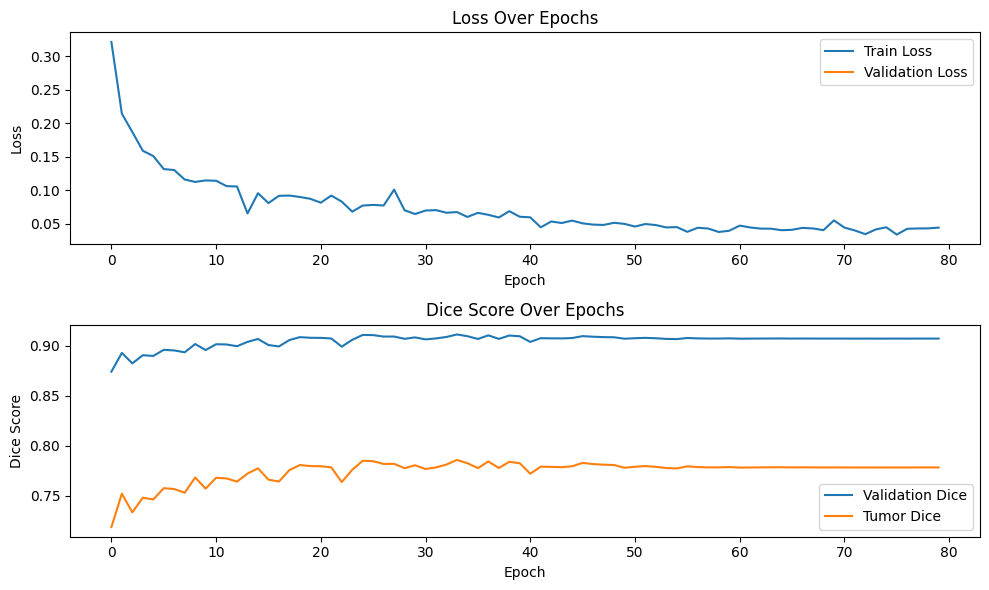

In [8]:
def plot_metrics(metrics):
    plt.figure(figsize=(10, 6))

    # Plot loss
    plt.subplot(2, 1, 1)
    plt.plot(metrics["train_loss"], label="Train Loss")
    plt.plot(metrics["val_loss"], label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Dice scores
    plt.subplot(2, 1, 2)
    plt.plot(metrics["val_dice"], label="Validation Dice")
    if "val_dice_per_class" in metrics:
        val_dice_per_class = metrics["val_dice_per_class"]
        if len(val_dice_per_class) > 0:
            plt.plot([c[1] for c in val_dice_per_class], label="Tumor Dice")
    plt.title("Dice Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Load metrics.json for a specific fold
import json
fold_idx = 0  # Replace with the desired fold index
with open(f"{experiment_dir}/fold_{fold_idx+1}/metrics.json", "r") as f:
    metrics = json.load(f)

plot_metrics(metrics)


In [9]:
torch.backends.cudnn.benchmark = False

model.load_state_dict(torch.load(os.path.join(fold_dir,"best_metric_model.pth")))
# Evaluation on Test Data
test_loader = DataLoader(
    CacheDataset(data=fold_splits[fold_idx]["test_files"], transform=test_transforms, cache_rate=0.1, num_workers=4),
    batch_size=batchsize, shuffle=True, num_workers=4
)


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


In [15]:
# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

post_label = AsDiscrete(to_onehot=numberofclasses+1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses+1)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

meandiceperclass = np.zeros([numberofclasses+1])

# Open a file to save the results
output_file = f"{fold_dir}/dice_scores_output.txt"
with open(output_file, "w") as f:
    f.write("Patient-wise Dice Scores and Mean Dice Score:\n\n")

    with torch.no_grad():
        for step, batch in enumerate(test_loader):
            pt_name = fold_split["test_files"][step]["image"].split("/")[-3]
            patient_info = f"Patient: {pt_name} / {fold_split['test_files'][step]['image'].split('/')[-1]}"
            print(patient_info)

            # Save patient info to file
            with open(output_file, "a") as f:
                f.write(f"{patient_info}\n")

            val_inputs, val_labels = (batch["image"].cuda(), batch["mask"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.5)
            
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dm = dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            print(dm[0])

            # Save per-class dice scores for this patient to file
            with open(output_file, "a") as f:
                f.write(f"Dice scores: {dm[0]}\n")
            
            meandiceperclass = meandiceperclass + dm[0]
        
        meandiceperclass = meandiceperclass / (step + 1)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
        
        # Print mean Dice scores
        print("Mean Dice Per Class:", meandiceperclass)
        print("Overall Mean Dice:", mean_dice_val)

        # Save mean Dice scores to file
        with open(output_file, "a") as f:
            f.write("\nMean Dice Per Class:\n")
            f.write(f"{meandiceperclass}\n")
            f.write("\nOverall Mean Dice:\n")
            f.write(f"{mean_dice_val}\n")

print(f"Results saved to {output_file}")


Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9993, 0.8028], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9982, 0.8845], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9900, 0.6254], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9991, 0.8353], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9950, 0.6565], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9983, 0.7578], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9959, 0.5898], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9979, 0.8759], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9904, 0.8179], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9971, 0.8472], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
metatensor([0.9983, 0.8992], device='cuda:0')

In [20]:
# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

post_label = AsDiscrete(to_onehot=numberofclasses+1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses+1)
hd_metric = HausdorffDistanceMetric(include_background=True, distance_metric='euclidean', percentile=95)

meanhd95perclass = np.zeros([numberofclasses+1])

# Open a file to save the results
output_file = f"{fold_dir}/hd95_scores_output.txt"
with open(output_file, "w") as f:
    f.write("Patient-wise HD95 Scores and Mean HD95 Score:\n\n")

    with torch.no_grad():
        for step, batch in enumerate(test_loader):
            pt_name = fold_split["test_files"][step]["image"].split("/")[-3]
            patient_info = f"Patient: {pt_name} / {fold_split['test_files'][step]['image'].split('/')[-1]}"
            print(patient_info)

            # Save patient info to file
            with open(output_file, "a") as f:
                f.write(f"{patient_info}\n")

            val_inputs, val_labels = (batch["image"].cuda(), batch["mask"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.5)
            
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            hd = hd_metric(y_pred=val_output_convert, y=val_labels_convert)
            print(hd[0])

            # Save per-class HD95 scores for this patient to file
            with open(output_file, "a") as f:
                f.write(f"HD95 scores: {hd[0]}\n")
            
            meanhd95perclass = meanhd95perclass + hd[0].cpu().detach().numpy()
        
        meanhd95perclass = meanhd95perclass / (step + 1)
        mean_hd_val = hd_metric.aggregate().item()
        hd_metric.reset()
        
        # Print mean HD95 scores
        print("Mean HD95 Per Class:", meanhd95perclass)
        print("Overall Mean HD95:", mean_hd_val)

        # Save mean HD95 scores to file
        with open(output_file, "a") as f:
            f.write("\nMean HD95 Per Class:\n")
            f.write(f"{meanhd95perclass}\n")
            f.write("\nOverall Mean HD95:\n")
            f.write(f"{mean_hd_val}\n")

print(f"Results saved to {output_file}")


Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0., 2.], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0., 2.], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([2.8284, 6.4031], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0.0000, 2.2361], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([1.0000, 7.0640], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0.0000, 2.8284], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0.0000, 5.8137], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0., 2.], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([2.0000, 3.1623], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0.0000, 2.2361], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0., 2.], device='cuda:0')
Patient: Planning-CTs / CT-Plan-image.nii.gz
tensor([0.0000, 2.4652], devic

In [24]:
import os
import numpy as np
import nibabel as nib
import torch
from monai.inferers import sliding_window_inference

def save_evaluation_results(eval_loader, model, output_dir, device, eval_files, roi_size, overlap=0.5):
    """
    Save evaluation results (image, ground truth, and predictions) as NIfTI files, preserving metadata.

    Parameters:
        eval_loader (DataLoader): DataLoader for evaluation dataset.
        model (torch.nn.Module): Trained model.
        output_dir (str): Directory to save evaluation results.
        device (torch.device): Device (CPU/GPU) to use for inference.
        eval_files (list): List of evaluation files.
        roi_size (tuple): ROI size for sliding window inference.
        overlap (float): Overlap for sliding window inference.
    """
    model.eval()
    with torch.no_grad():
        print("\nStarting evaluation and saving results...\n")
        for i, eval_data in enumerate(eval_loader):
            pt_name = eval_files[i]["image"].split("/")[-2]
            print(f"Processing Patient: {pt_name}")

            # Load the original NIfTI file to get the affine matrix and header
            original_nifti = nib.load(eval_files[i]["image"])
            affine = original_nifti.affine
            header = original_nifti.header

            # Perform sliding window inference
            eval_inputs = eval_data["image"].to(device)
            eval_outputs = sliding_window_inference(
                eval_inputs, roi_size, sw_batch_size=4, predictor=model, overlap=overlap
            )

            # Convert tensors to numpy arrays
            image = eval_data["image"][0, 0].cpu().numpy()
            mask = eval_data["mask"][0, 0].cpu().numpy()
            predicted = torch.argmax(eval_outputs, dim=1).detach().cpu().numpy()[0]

            # Create the output directory for this patient
            patient_output_dir = os.path.join(output_dir, pt_name)
            os.makedirs(patient_output_dir, exist_ok=True)

            # Save as NIfTI files using the original affine matrix and header
            nib.save(nib.Nifti1Image(image, affine, header), os.path.join(patient_output_dir, f"{pt_name}_image.nii"))
            nib.save(nib.Nifti1Image(mask, affine, header), os.path.join(patient_output_dir, f"{pt_name}_mask.nii"))
            nib.save(nib.Nifti1Image(predicted.astype(np.int16), affine, header), os.path.join(patient_output_dir, f"{pt_name}_predicted.nii"))

            print(f"Results saved for {pt_name} at {patient_output_dir}")

# Example usage
save_evaluation_results(
    eval_loader=test_loader,  # Test DataLoader
    model=model,              # Trained model
    output_dir=os.path.join(experiment_dir, f"fold_{fold_idx+1}", "evaluation_results"),  # Directory for saving results
    device=device,            # CPU or GPU device
    eval_files=fold_split["test_files"],    # Test file paths
    roi_size=(64, 64, 64),    # ROI size for sliding window
    overlap=0.5               # Overlap for sliding window
)



Starting evaluation and saving results...

Processing Patient: 2013KEFR
Results saved for 2013KEFR at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/evaluation_results/2013KEFR
Processing Patient: 2013HOJA
Results saved for 2013HOJA at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/evaluation_results/2013HOJA
Processing Patient: 2012JOJA
Results saved for 2012JOJA at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/evaluation_results/2012JOJA
Processing Patient: 2011TSMA
Results saved for 2011TSMA at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/evaluation_results/2011TSMA
Processing Patient: 2012ADJU
Results saved for 2012ADJU at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/evaluation_results/2012ADJU
Processing Patient: 2015SCWI
Results saved for 2015SCWI at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s4/fold_1/evaluation_results/2015SCWI
Pr